#Costruzione di una rete neurale per risolvere un problema di regressione parametrica

##Introduzione
Il file *SFRH_IllustrisTNG.npy* contiene 1000 simulazioni idrodinamiche della star-formation rate density $SFRD(z)$ a 100 valori equispaziati di redshift $z \in (0.0, 7.0)$. Ciascuna simulazione è stata ottenuta con un diverso set di parametri cosmologici ed astrofisici  
$\vec{\theta} = \{\Omega_m, \sigma_8, A_{SN1}, A_{SN2}, A_{AGN1}, A_{AGN2}\}$.

contenuti nel file *params_IllustrisTNG.txt*, ordinati secondo le simulazioni prodotte.

In questo notebook viene illustrata la costruzione e l'ottimizzazione di una rete neurale capace di predire il set parametri $\vec{\theta}$ associato alle misure di $SFRD(z)$ ed eventualmente di evidenziare se tutti i parametri previsti siano veramente utili alla descrizione del modello.

Siccome la rete non risulta in grado di predire due dei sei parametri ipotizzati per il modello, nella successiva sezione del notebook vengono illustrati tentativi di soluzione del problema e spiegazioni a questo comportamento anomalo.

Infine la rete viene implementata con una nuova loss function al fine di predire gli errori sui parametri.


In [200]:
import torch
import torch.nn as nn
import sys,os,time
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [201]:
#per eseguire le operazioni su GPU se disponibili
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


Vengono caricate le simulazioni e i relativi parametri rispettivamente nei numpy arrays *SFRD* e *parameters*. Si verifica che le dimensioni siano corrette, ossia che le simulazioni siano 1000 con 100 misure ciascuna per ogni valore di redshift e che i parametri siano 6 per ciascuna simulazione prodotta.

In [202]:
SFRD = np.load('SFRH_IllustrisTNG.npy')
print(SFRD.shape)
parameters = np.loadtxt('params_IllustrisTNG.txt')
print(parameters.shape)

(1000, 100)
(1000, 6)


Nel seguente grafico vengono selezionate 5 simulazioni e riportate le corrispondenti misure di $SFRD(z)$ per studiarne l'andamento in funzione del redshift. Nella legenda sono elencati i rispettivi set di parametri.

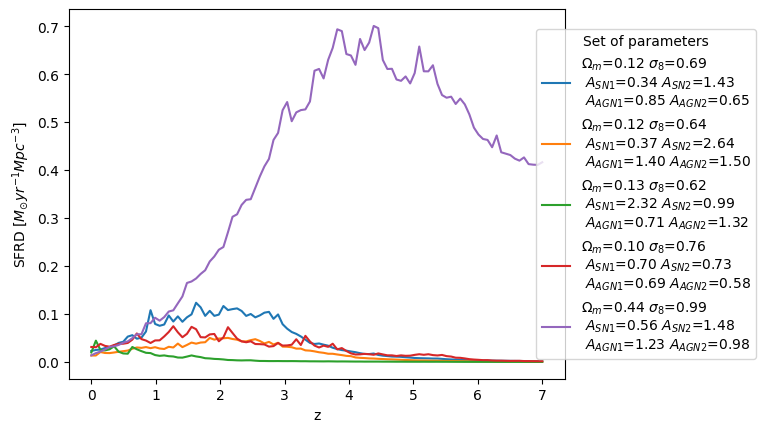

In [203]:
z = np.linspace(0.0, 7.0, 100)
selected = np.array([722, 123, 801, 138, 772])
SFRD_sample = np.zeros((5, SFRD.shape[1]))
for counter, i in enumerate(selected):
  SFRD_i = SFRD[i,:]
  parameters_i = parameters[i,:]
  plt.plot(z, SFRD_i, label = f'$\Omega_m$={parameters_i[0]:.2f} $\sigma_8$={parameters_i[1]:.2f} \n $A_{{SN1}}$={parameters_i[2]:.2f} $A_{{SN2}}$={parameters_i[3]:.2f} \n $A_{{AGN1}}$={parameters_i[4]:.2f} $A_{{AGN2}}$={parameters_i[5]:.2f}')
  SFRD_sample[counter,:] = SFRD_i
plt.xlabel('z')
plt.ylabel('SFRD [$M_{\odot}yr^{-1}Mpc^{-3}$]')
plt.legend(loc = 'right', title = 'Set of parameters', fontsize = '10', bbox_to_anchor=(1.4,0.5))
plt.show()

Tutte le simulazioni graficate hanno lo stesso andamento: i valori di $SFRD(z)$ crescono fino ad un certo range di redshift, diverso per ciascuna simulazione e non centrato nell'intervallo $(0.0, 7.0)$, qui si assestano su un plateau più o meno largo, per poi decrescere verso 0 a più grandi valori di $z$.
Confrontando le simulazioni, le misure di $SFRD(z)$ variano in range finiti e positivi ma anche molto diversi tra loro, ad esempio ho scelto di rappresentare una simulazione che raggiunge un picco massimo pari ad almeno 7 volte i valori massimi delle altre simulazioni. Siccome la dispersione dei dati è variabile nelle simulazioni, è importante standardizzare il dataset prima di fornirlo alla rete per uniformare le ampiezze e velocizzare la convergenza.

Di seguito vengono graficate nuovamente le 5 simulazioni selezionate ma questa volta standardizzate tramite media e varianza del campione di 100 misure di ciascuna simulazione, lo stesso verrà fatto su tutte le simulazioni usate per il training della rete.

Si nota che, una volta standardizzati, le misure di ciascuna simulazione variano in range approssivamente centrati in 0 e confrontabili tra loro.

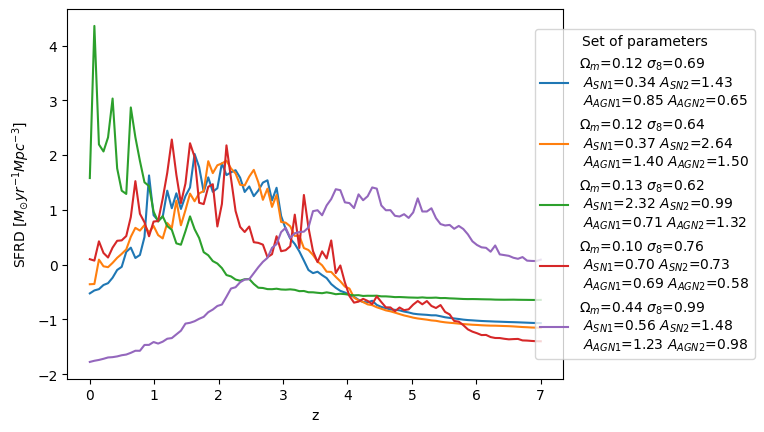

In [204]:
mean = np.tile(np.mean(SFRD_sample, dtype=np.float64, axis=1), (100,1)).T #mean of SFRD values for each simulation
std = np.tile(np.std(SFRD_sample, dtype=np.float64, axis=1), (100,1)).T #std of SFRD values for each simulation
SFRD_stand = (SFRD_sample-mean)/std


#mean = np.mean(SFRD_sample, dtype=np.float64)
#std = np.std(SFRD_sample, dtype=np.float64)
#SFRD_stand = (SFRD_sample-mean)/std

for counter, i in enumerate(selected):
  stand = SFRD_stand[counter,:]
  parameters_i = parameters[i,:]
  plt.plot(z, stand, label = f'$\Omega_m$={parameters_i[0]:.2f} $\sigma_8$={parameters_i[1]:.2f} \n $A_{{SN1}}$={parameters_i[2]:.2f} $A_{{SN2}}$={parameters_i[3]:.2f} \n $A_{{AGN1}}$={parameters_i[4]:.2f} $A_{{AGN2}}$={parameters_i[5]:.2f}')
plt.xlabel('z')
plt.ylabel('SFRD [$M_{\odot}yr^{-1}Mpc^{-3}$]')
plt.legend(loc = 'right', title = 'Set of parameters', fontsize = '10', bbox_to_anchor=(1.4,0.5))
plt.show()

Nel seguente grafico sono rappresentati i valori medi di ciascun parametro su tutte le simulazioni e le barre di errore evidenziano gli intervalli tra valore minimo e valore massimo. Siccome anche in questo caso le scale sono diverse, nella creazione del dataset verranno normalizzati i parametri in modo che abbiano valori tra 0 e 1. In questo modo le scale vengono uniformate per facilitare l'apprendimento della rete.

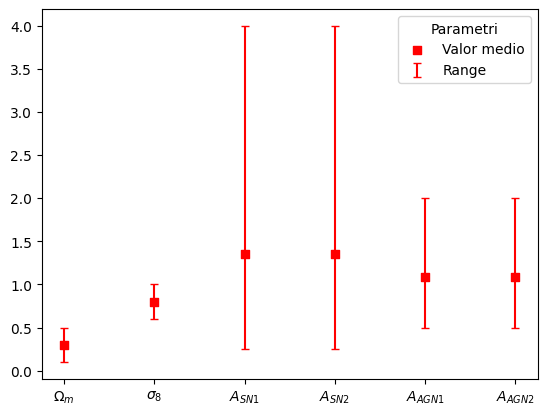

In [205]:
for i in range (6):
  mean_parameters = np.mean(parameters, axis = 0)
  min_parameters = np.min(parameters, axis = 0)
  max_parameters = np.max(parameters, axis = 0)

x = np.arange(1,7)
x_labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']
errorbars = [mean_parameters-min_parameters, max_parameters-mean_parameters]

plt.scatter(x, mean_parameters, marker='s', color='r', label = 'Valor medio')
plt.errorbar(x, mean_parameters, yerr=errorbars, fmt='None', capsize=3, ecolor='r', label='Range')

plt.xticks(x, x_labels)

plt.legend(loc = 'upper right', title = 'Parametri', fontsize = '10')
plt.show()

Di seguito si riporta lo stesso grafico dopo aver normalizzato i parametri per verificarne il corretto riscalamento.

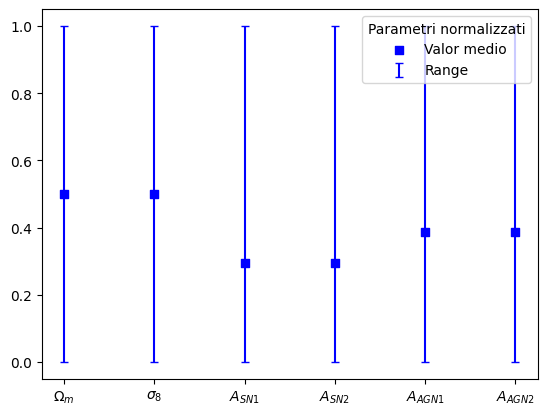

In [206]:
parameters_norm = (parameters - min_parameters) / (max_parameters - min_parameters)
for i in range (6):
  mean_parameters = np.mean(parameters_norm, axis = 0)
  min_parameters = np.min(parameters_norm, axis = 0)
  max_parameters = np.max(parameters_norm, axis = 0)
x = np.arange(1,7)
x_labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']
errorbars = [mean_parameters-min_parameters, max_parameters-mean_parameters]

plt.scatter(x, mean_parameters, marker='s', color='b', label = 'Valor medio')
plt.errorbar(x, mean_parameters, yerr=errorbars, fmt='None', capsize=3, ecolor='b', label='Range')

plt.xticks(x, x_labels)

plt.legend(loc = 'upper right', title = 'Parametri normalizzati', fontsize = '10')
plt.show()

###Hyper-parameters
Vengono impostati i valori degli hyper_parameters che ottimizzano la rete. Il processo di ottimizzazione è descritto nel paragrafo *Ottimizzazione dei parametri*.

In [207]:
#hyper-parameters
seed = 2
learning_rate = 2e-5
epochs = 700
hidden_layers = 3
hidden_size = np.array([70, 70, 70])
batch_size = 30
dropout_rate = 0.5
weight_decay = 0.0
patience = 50
stop_criterion = 100
min_valid_loss = 1e10

f_model_parameters = 'model_parameters.pt'

###Creazione del dataset
Come anticipato, le misure di SFRD vengono standardizzate e i valori dei parametri normalizzati tra 0 e 1.
Il dataset viene suddiviso in training, validation e test set rispettivamente con 750, 150 e 150 simulazioni ciascuno. I dati vengono suddivisi nei datasets dopo essere stati rimescolati in modo che l'apprendimento della rete avvenga in modo casuale.

In [208]:
def create_dataset(mode, SFRD, parameters, batch_size, seed):

  data_set = make_dataset(mode, SFRD, parameters, seed)

  return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)

#create training, validation and test datasets, shuffling them to pick randomly the data to put in each dataset

class make_dataset():
  def __init__(self, mode, SFRD, parameters, seed):
    sims = SFRD.shape[0] #number of simulations is 1000

    #standardization of SFRD over values of z per simulation
    mean = np.tile(np.mean(SFRD, dtype=np.float64, axis=1), (100,1)).T #mean of SFRD values for each simulation
    std = np.tile(np.std(SFRD, dtype=np.float64, axis=1), (100,1)).T #std of SFRD values for each simulation
    SFRD = (SFRD-mean)/std

    #standardization of SFRD over the values of all simulations
    #mean = np.mean(SFRD, dtype=np.float64)
    #std = np.std(SFRD, dtype=np.float64)
    #SFRD = (SFRD-mean)/std

    #normalization of parameters (each one between 0 and 1)
    min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
    max_params = np.max(parameters, axis=0)
    parameters = (parameters - min_params) / (max_params - min_params)

    if   mode=='train':
      size, offset = int(sims*0.70), int(sims*0.00)
    elif mode=='valid':
      size, offset = int(sims*0.15), int(sims*0.70) #offset because the first 70% of data is already in the training data
    elif mode=='test':
      size, offset = int(sims*0.15), int(sims*0.85)
    elif mode=='all':
      size, offset = int(sims*1.00), int(sims*0.00)
    else:
      raise Exception('Wrong name!')

    # define size, input and output arrays containing the data
    self.size   = size
    self.input  = torch.zeros((size,100), dtype=torch.float)
    self.output = torch.zeros((size,6),    dtype=torch.float)

    #shuffling data before splitting into the sets
    np.random.seed(seed)
    idx = np.arange(sims)
    np.random.shuffle(idx)
    idx = idx[offset:offset+size] #depending on the mode you shuffle indexes of the right data set, from the offset to the offset+size of the data set

    self.input = torch.tensor(SFRD[idx], dtype=torch.float32) #SFRD[idx] has dimensions (size, 100)
    self.output = torch.tensor(parameters[idx], dtype=torch.float32) #parameters[idx] has dimensions (size, 6)

  def __len__(self):
        return self.size

  def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data for training and validation
train_loader = create_dataset('train', SFRD, parameters, batch_size, seed) #training data
valid_loader = create_dataset('valid', SFRD, parameters, batch_size, seed) #validation data

###Costruzione del modello
Viene usata un'architettura del tipo Fully Connected Linear Network con LeakyReLU come funzione di attivazione, necessaria per trattare un modello complesso e non lineare come questo.

La dimensione dell'input layer è 100 perché a ciascuna simulazione corrispondono 100 misure, mentre l'output layer contiene 6 neuroni, una per ciascun parametro. Nella sezione *Ottimizzazione dei parametri* è commentata la scelta del numero di hidden layers e del numero di neuroni che compongono ciascun layer.

In [209]:
model = nn.Sequential(
            nn.Linear(SFRD.shape[1], hidden_size[0]), #input layer has 100 neurons because each simulation has 100 data
            nn.LeakyReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.LeakyReLU(),
            #nn.Linear(hidden_size[2], hidden_size[3]),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size[2], parameters.shape[1]) #output layer has 6 neurons, one for each parameter
            )

model.to(device=device) #move the model to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('Numero complessivo dei parametri che compongono la rete = %d'%network_total_params)

Numero complessivo dei parametri che compongono la rete = 17436


###Definizione della loss function
Viene utilizzata la Mean Square Error loss function, della forma

$$ \sum_{p \in {\rm params}} \sum_{ i \in {\rm batch}} (p_i^{true}-p_i^{pred})^2$$

che somma i quadrati delle differenze tra valore vero e valore predetto dalla rete per ciascun parametro sulle simulazioni contenute nel batch e sugli stessi parametri.

In [210]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_predicted, y_true):
        return torch.sum((y_true-y_predicted)**2.) #MSE loss function
        #return torch.log(torch.sum((y_true-y_predicted)**2.)) #logarithmic loss function

loss_func = loss_function()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay) #Adam optimizer for stochastic gradient descent

###Training e validation

In [211]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

# Define a scheduler to change the learning rate after number of epochs=patience without improvement
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-10)
current_lr=scheduler.get_last_lr()
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    #training
    train_loss, points = 0.0, 0

    model.train()
    for SFRD_train, params_train in train_loader:  #do a loop over batches

        # get the number of elements in the batch
        b_size =  SFRD_train.shape[0]

        # move data to GPU
        SFRD_train   = SFRD_train.to(device)
        params_train = params_train.to(device)

        # compute the value predicted by the network by linear combination with the current set of parameters
        params_pred  = model(SFRD_train)

        # compute loss
        loss = loss_func(params_pred, params_train)

        # compute cumulative loss over the elements in the batch and number of examples used
        train_loss += (loss.item())*b_size #.item() returns tensors with one element as standard python numbers
        points     += b_size #at the end of the iteration is the size of the training set because it sums the elements in the batches

        optimizer.zero_grad() # set gradient to zero to compute the gradient on the next set of improved parameters
        loss.backward() #compute the gradient of the loss function with respect to the parameters
        optimizer.step() #improve the parameters according to the learning rate

    # get the average training loss over the batches for this epoch
    train_loss /= points
    train_value[epoch]=train_loss #array with the improvements of the loss function over the epochs

    # do validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader: # do a loop over batches
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the number of elements in the batch
            b_size = SFRD_val.shape[0]

            # move data to the GPU
            SFRD_val   = SFRD_val.to(device)
            params_val = params_val.to(device)

            # compute prediction by the network
            params_pred = model(SFRD_val)

            # compute loss
            loss = loss_func(params_pred, params_val)

            # compute cumulative loss over the elements in the batch and number of examples used
            valid_loss += (loss.item())*b_size
            points     += b_size

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the learning rate if needed

    if current_lr!=scheduler.get_last_lr():
        print('Learning rate updated to', scheduler.get_last_lr())
        current_lr=scheduler.get_last_lr()

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e  %.3e'%(epoch, train_loss, valid_loss, valid_loss-train_loss), end='') #prints results for every epoch on both training and validation sets
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model_parameters) #saves in the file f_model_parameters just the states of the model that improve learning
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model so far)')
    else:
        print('')
    #stop training if there is no improvement after number of epochs=stop_criterion
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not improved after ',stop_criterion,' epochs')
        print('Last Learning Rate', scheduler.get_last_lr())
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

000 4.276e+01 4.202e+01  -7.392e-01 (best-model so far)
001 4.104e+01 4.021e+01  -8.238e-01 (best-model so far)
002 3.922e+01 3.834e+01  -8.865e-01 (best-model so far)
003 3.739e+01 3.638e+01  -1.009e+00 (best-model so far)
004 3.528e+01 3.431e+01  -9.617e-01 (best-model so far)
005 3.306e+01 3.202e+01  -1.038e+00 (best-model so far)
006 3.071e+01 2.946e+01  -1.250e+00 (best-model so far)
007 2.815e+01 2.686e+01  -1.290e+00 (best-model so far)
008 2.550e+01 2.437e+01  -1.137e+00 (best-model so far)
009 2.308e+01 2.210e+01  -9.860e-01 (best-model so far)
010 2.094e+01 2.008e+01  -8.647e-01 (best-model so far)
011 1.898e+01 1.838e+01  -5.999e-01 (best-model so far)
012 1.743e+01 1.703e+01  -4.050e-01 (best-model so far)
013 1.627e+01 1.599e+01  -2.789e-01 (best-model so far)
014 1.531e+01 1.522e+01  -9.225e-02 (best-model so far)
015 1.466e+01 1.465e+01  -1.368e-02 (best-model so far)
016 1.414e+01 1.424e+01  1.005e-01 (best-model so far)
017 1.374e+01 1.394e+01  1.971e-01 (best-model so

[]

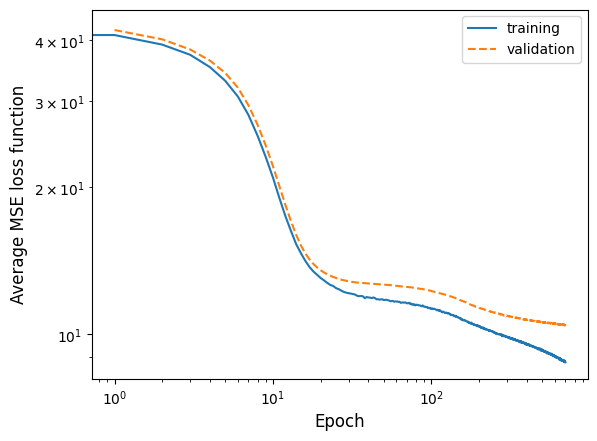

In [212]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='training') #train_value contains the values of the loss function for each epoch of the training set
plt.plot(epoche+1,valid_value,ls='--',label='validation') #valid_value contains the values of the loss function for each epoch of the validation set

plt.legend()
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average MSE loss function", fontsize=12)
plt.loglog()

##Ottimizzazione dei parametri

###Learning rate


Il learning rate è stato il parametro più semplice da ottimizzare.
Impostando il learning rate a $10^{-2}$ non si verifica nessuna convergenza nella loss function.

Abbassandolo a $10^{-3}$ e poi a $10^{-4}$, come si può vedere dai rispettivi grafici di seguito, da un certo numero di epoche in poi la loss function valutata sul validation set comincia a crescere mentre quella valutata sul traingin set continua a diminuire.


Un learning rate dell'ordine di $10^{-5}$ (impostato come hyper parameter della rete) invece risulta in una buona convergenza della validation loss function. Non sono stati scelti valori inferiori a questo per evitare di rallentare troppo il processo di training della rete.



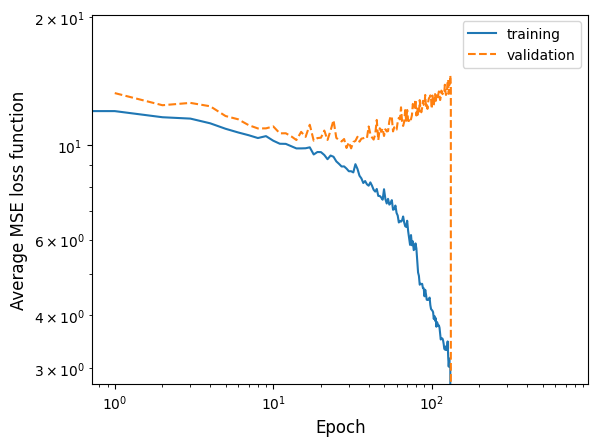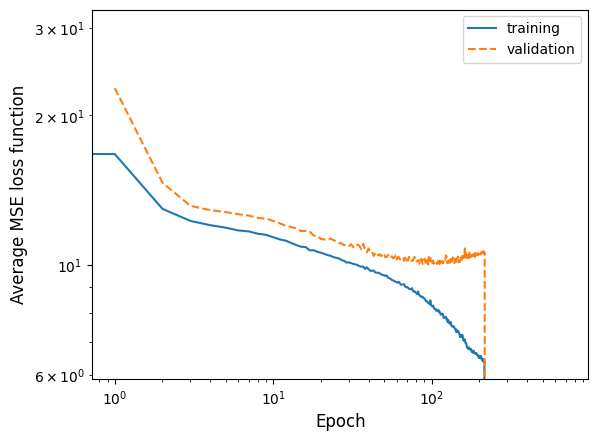

###Epochs
Fissato il learning rate a $2 \cdot 10^{-5}$, il numero di epoche è stato scelto in modo tale da permettere alla rete di apprendere sufficientemente bene ma prestando attenzione ad evitare l'overfitting.
Il grafico seguente illustra l'andamento della loss function lungo un numero elevato di epoche (epochs = 3000). Dopo circa un migliaio di epoche appare evidente che mentre la training loss function continua a decrescere, la validation loss function si assesta al valore minimo e non migliora più. Questo significa che un numero troppo elevato di epoche porta all'overtraininig della rete. Per evitarlo si eseguono 700 epoche, in corrispondenza delle quali inizia a verificarsi il comportamento descritto sopra, ossia della divergenza delle due loss functions.

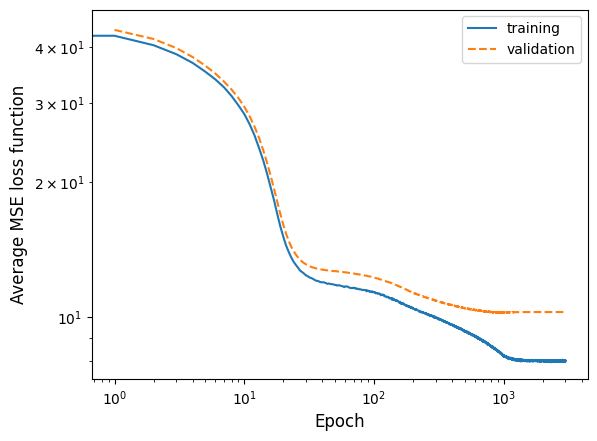

###Hidden-layers e hidden-size
Diversi valori di questi parametri non apportano modifiche significative all'apprendimento della rete. Sempre seguendo la logica di evitare l'overfitting si è testata la rete partendo da 2 hidden layers con un basso numero di neuroni per poi aumentare sia i layers che il numero di neuroni per ciascun layer.

Prendendo come riferimento il valore minimo della validation loss function e il valore della loss function valutata sul campione test, il numero di layer più soddisfacente è 3 (ho testato la rete fino a 5 hidden layers) con circa una settantina di neuroni ciascuno (ma il valore di hidden_size non è risultato molto significativo) per un totale di 17436 parametri.




*   I parametri patience e criterion sono stati utilizzati più che altro in fase di ottimizzazione per evitare che il processo di training continuasse per molte epoche con set di parametri poco performanti
*   Regolarizzare la rete non ha apportato miglioramenti, per cui il parametro di weight decay è stato lasciato a 0. Può essere che la dimensione dei mini-batches (*batch-size*=30) fornisca di per sé un contributo sufficiente alla regolarizzazione, dato che ottimizzare la rete basandosi su campioni di dimensioni sufficientemente ridotte rispetto all'intero set di dati consente una migliore generalizzazione. Non è stata scelta una dimensione inferiore per evitare sia che il batch non fosse abbastanza rappresentativo del campione e sia rallentamenti dovuti al maggior numero di iterazioni per epoca.



##Predizioni dei parametri sul test set

In [213]:
# get the test data
test_loader = create_dataset('test', SFRD, parameters, batch_size, seed) #test data

# load the best-model and move it to the GPU because I want to use the best set of parameters found over training
model.load_state_dict(torch.load(f_model_parameters))
model.to(device=device)

#array where to store the true set of parameters and corresponding SFRD sims selected from the files for the test dataset
SFRD_T=np.zeros((int(SFRD.shape[0]*0.75),100), dtype=np.float32)
params_T = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)
#array where to store the network predictions for the parameters
params_N = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)

# loop over batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        # get the number of elements in the batch
        b_size = SFRD_test.shape[0]

        # move data to GPU
        SFRD_test   = SFRD_test.to(device)
        params_test = params_test.to(device)

        # make prediction using network
        params_pred = model(SFRD_test)

        SFRD_T[points:points+b_size, :] = SFRD_test.cpu().numpy()
        params_T[points:points+b_size, :] = params_test.cpu().numpy() #this array has the true values of the parameters used for the SFRD data in the test dataset
        params_N[points:points+b_size, :] = params_pred.cpu().numpy() #this array has the values predicted by the net for the parameters used for the SFRD data in the test dataset

        loss = loss_func(params_pred, params_test)

        # compute cumulative loss and number of examples used
        test_loss += (loss.item())*b_size
        points    += b_size

# get the average test loss
test_loss /= points

print('test loss = %.3e'%test_loss) #value of the loss function fot the test

#denormalize the parameters

min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
max_params = np.max(parameters, axis=0)

params_T = params_T*(max_params-min_params) + min_params
params_N = params_N*(max_params-min_params) + min_params

test loss = 9.989e+00


<ipython-input-213-a7274da697a7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f_model_parameters))


##Plot dei risultati
Di seguito vengono graficati in ascissa i valori veri dei parametri del set selezionato per il test della rete, mentre in ordinata i valori predetti dalla rete. Ci si aspetta quindi che i dati si distribuiscano lungo la bisettrice graficata in verde. Per meglio verificare questo andamento, l'intervallo in cui variano i valori veri dei parametri è stato suddiviso in 8 bins ed è stata calcolata la media dei parametri predetti per ciascun bin (in rosso nel grafico).



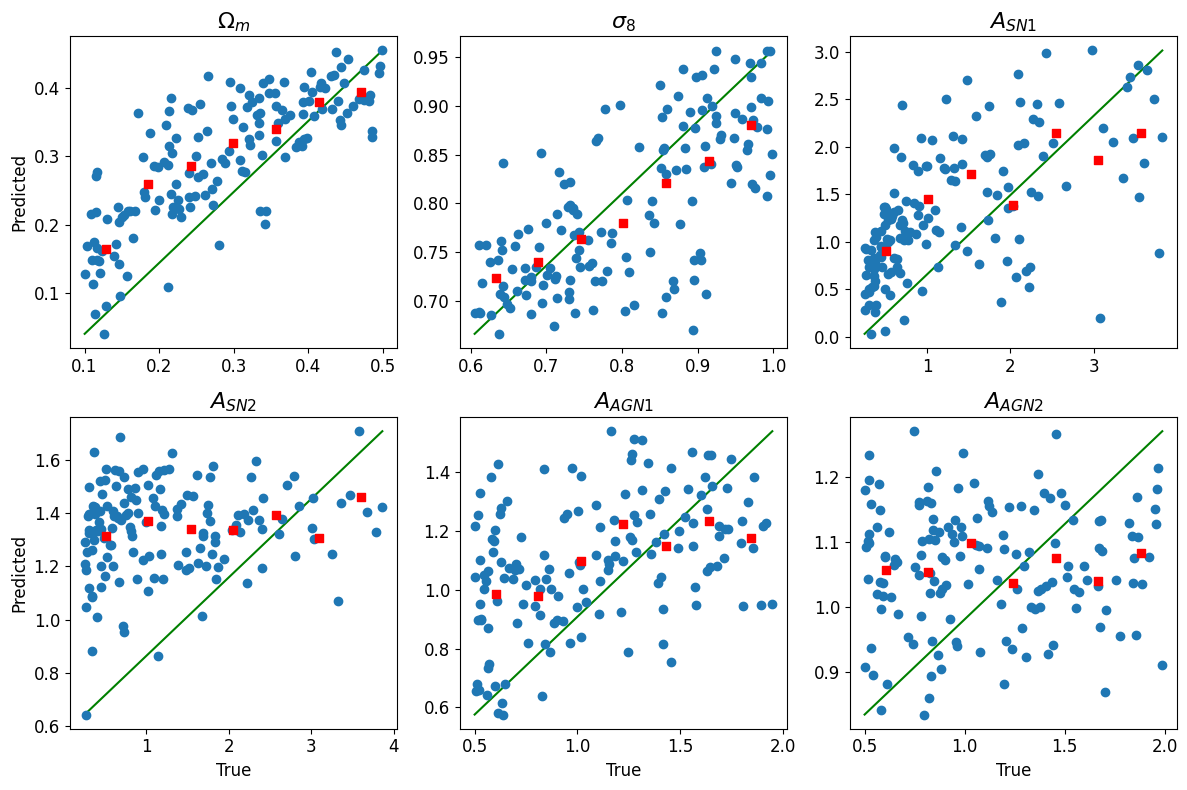

In [214]:
import scipy.stats as stats

bin_edges = []
min_T = np.zeros(6)
max_T = np.zeros(6)
min_N = np.zeros(6)
max_N = np.zeros(6)

for i in range(params_T.shape[1]):
  min_T[i] = np.min(params_T[:,i])
  max_T[i] = np.max(params_T[:,i])
  bin_edges.append(np.linspace(min_T[i], max_T[i], 8))

for i in range(params_N.shape[1]):
  min_N[i] = np.min(params_N[:,i])
  max_N[i] = np.max(params_N[:,i])

fig, axes = plt.subplots(2,3,figsize=(12,8))

title = ['$\Omega_m$', '$\sigma_8$', "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN1}$", "$A_{AGN2}$"]

for i, ax in enumerate(axes.flat):
  ax.scatter(params_T[:,i], params_N[:,i], zorder=1)

  ax.plot([min_T[i],max_T[i]],[min_N[i],max_N[i]], color = 'g', zorder=0)

  mean, bin_edges_x, binnumber = stats.binned_statistic(
      params_T[:,i], params_N[:,i], statistic=np.mean, bins=bin_edges[i])

  ax.scatter(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, marker='s',color='r')


  ax.set_title(title[i], fontsize=16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

for i in range(3):
    axes[1, i].set_xlabel('True', fontsize=12)

for i in range(2):
    axes[i, 0].set_ylabel('Predicted', fontsize=12)

plt.tight_layout()

plt.show()

##Discussione dei risultati e possibili soluzioni
Si ottengono delle buone predizioni per $\Omega_m$ e $\sigma_8$, accettabili per $A_{SN1}$ e $A_{AGN1}$, invece per niente corrette per $A_{SN2}$ e $A_{AGN2}$.


*   Inizialmente ho ipotizzato che a causare questo errore fosse una scelta errata di hyper-parameters, quindi come prima cosa ho incrementato la complessità del modello, sia a livello di architettura della rete (aumentando il numero di layers e di neuroni), sia incrementando le epoche di training. Come evidenziato nel paragrafo sull'ottimizzazione dei parametri nessuna delle modifiche si è rivelata utile, anzi.
*   Allora ho ipotizzato il problema opposto, ossia che la rete risentisse di un overtraining causa a sua volta di una sbagliata predizione dei parametri sul campione di test. Ma il problema non è stato risolto nemmeno quando ho semplificato il modello usando un solo hidden layer e riducendo il numero di epoche.
*   Come già menzionato non si è rivelato utile regolarizzare la rete impostando un valore non nullo di weight decay (ho usato valori tipici dell'ordine di grandezza di $10^{-2}$ e $10^{-4}$).



###Weighted loss function



*   Allora ho tentato un diverso approccio, definidendo una weighted loss function associando un peso maggiore alle differenze relative ai parametri che la rete non riesce a predire:



In [215]:
class loss_function_1(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_predicted, y_true):
        params_weights = torch.tensor([0.5, 0.5, 1.0, 4.0, 1.0, 4.0])
        return torch.dot(torch.sum((y_true-y_predicted)**2., axis=0), params_weights)

####Training della rete con weighted loss function

In [216]:
#hyper-parameters
seed = 2
learning_rate = 2e-5
epochs = 700
hidden_layers = 3
hidden_size = np.array([70, 70, 70])
batch_size = 30
dropout_rate = 0.5
weight_decay = 0.0
patience = 50
stop_criterion = 100
min_valid_loss = 1e10

f_model_1 = 'model_weighted_loss.pt'

In [217]:
def create_dataset(mode, SFRD, parameters, batch_size, seed):

  data_set = make_dataset(mode, SFRD, parameters, seed)

  return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)

#create training, validation and test datasets, shuffling them to pick randomly the data to put in each dataset

class make_dataset():
  def __init__(self, mode, SFRD, parameters, seed):
    sims = SFRD.shape[0] #number of simulations is 1000

    #standardization of SFRD over values of z per simulation
    mean = np.tile(np.mean(SFRD, dtype=np.float64, axis=1), (100,1)).T #mean of SFRD values for each simulation
    std = np.tile(np.std(SFRD, dtype=np.float64, axis=1), (100,1)).T #std of SFRD values for each simulation
    SFRD = (SFRD-mean)/std

    #standardization of SFRD over the values of all simulations
    #mean = np.mean(SFRD, dtype=np.float64)
    #std = np.std(SFRD, dtype=np.float64)
    #SFRD = (SFRD-mean)/std

    #normalization of parameters (each one between 0 and 1)
    min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
    max_params = np.max(parameters, axis=0)
    parameters = (parameters - min_params) / (max_params - min_params)

    if   mode=='train':
      size, offset = int(sims*0.70), int(sims*0.00)
    elif mode=='valid':
      size, offset = int(sims*0.15), int(sims*0.70) #offset because the first 70% of data is already in the training data
    elif mode=='test':
      size, offset = int(sims*0.15), int(sims*0.85)
    elif mode=='all':
      size, offset = int(sims*1.00), int(sims*0.00)
    else:
      raise Exception('Wrong name!')

    #shuffling data before splitting into the sets
    np.random.seed(seed)
    idx = np.arange(sims)
    np.random.shuffle(idx)
    idx = idx[offset:offset+size] #depending on the mode you shuffle indexes of the right data set, from the offset to the offset+size of the data set

    self.size = size
    self.input = torch.tensor(SFRD[idx], dtype=torch.float32) #SFRD[idx] has dimensions (size, 100)
    self.output = torch.tensor(parameters[idx], dtype=torch.float32) #parameters[idx] has dimensions (size, 6)

  def __len__(self):
        return self.size

  def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', SFRD, parameters, batch_size, seed) #training data
valid_loader = create_dataset('valid', SFRD, parameters, batch_size, seed) #validation data

In [218]:
model = nn.Sequential(
            nn.Linear(SFRD.shape[1], hidden_size[0]), #input layer has 100 neurons because each simulation has 100 data
            nn.LeakyReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.LeakyReLU(),
            #nn.Linear(hidden_size[2], hidden_size[3]),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size[2], parameters.shape[1]) #output layer has 6 neurons, one for each parameter
            )

model.to(device=device) #move the model to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('Numero complessivo dei parametri che compongono la rete = %d'%network_total_params)

Numero complessivo dei parametri che compongono la rete = 17436


In [219]:
class loss_function_1(nn.Module):
    def __init__(self):
        super(loss_function_1, self).__init__()
    def forward(self, y_predicted, y_true):
        params_weights = torch.tensor([0.5, 0.5, 1.0, 4.0, 1.0, 4.0])
        return torch.dot(torch.sum((y_true-y_predicted)**2., axis=0), params_weights)

loss_func_1 = loss_function_1()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay) #Adam optimizer for stochastic gradient descent

In [220]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

# Define a scheduler to change the learning rate after number of epochs=patience without improvement
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-10)
current_lr=scheduler.get_last_lr()
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    #training
    train_loss, points = 0.0, 0

    model.train()
    for SFRD_train, params_train in train_loader:  #do a loop over batches

        # get the number of elements in the batch
        b_size =  SFRD_train.shape[0]

        # move data to GPU
        SFRD_train   = SFRD_train.to(device)
        params_train = params_train.to(device)

        # compute the value predicted by the network by linear combination with the current set of parameters
        params_pred  = model(SFRD_train)

        # compute loss
        loss = loss_func_1(params_pred, params_train)

        # compute cumulative loss over the elements in the batch and number of examples used
        train_loss += loss.item()*b_size #.item() returns tensors with one element as standard python numbers
        points     += b_size #at the end of the iteration is the size of the training set because it sums the elements in the batches

        optimizer.zero_grad() # set gradient to zero to compute the gradient on the next set of improved parameters
        loss.backward() #compute the gradient of the loss function with respect to the parameters
        optimizer.step() #improve the parameters according to the learning rate

    # get the average training loss over the batches for this epoch
    train_loss /= points
    train_value[epoch]=train_loss #array with the improvements of the loss function over the epochs

    # do validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader: # do a loop over batches
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the number of elements in the batch
            b_size = SFRD_val.shape[0]

            # move data to the GPU
            SFRD_val   = SFRD_val.to(device)
            params_val = params_val.to(device)

            # compute prediction by the network
            params_pred = model(SFRD_val)

            # compute loss
            loss = loss_func_1(params_pred, params_val)

            # compute cumulative loss over the elements in the batch and number of examples used
            valid_loss += loss.item()*b_size
            points     += b_size

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the learning rate if needed

    if current_lr!=scheduler.get_last_lr():
        print('Learning rate updated to', scheduler.get_last_lr())
        current_lr=scheduler.get_last_lr()

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e'%(epoch, train_loss, valid_loss), end='') #prints results for every epoch on both training and validation sets
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model_1) #saves in the file f_model_parameters just the states of the model that improve learning
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model so far)')
    else:
        print('')
    #stop training if there is no improvement after number of epochs=stop_criterion
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not improved after ',stop_criterion,' epochs')
        print('Last Learning Rate', scheduler.get_last_lr())
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

000 7.344e+01 6.800e+01 (best-model so far)
001 6.990e+01 6.487e+01 (best-model so far)
002 6.669e+01 6.157e+01 (best-model so far)
003 6.308e+01 5.794e+01 (best-model so far)
004 5.897e+01 5.425e+01 (best-model so far)
005 5.476e+01 5.039e+01 (best-model so far)
006 5.064e+01 4.676e+01 (best-model so far)
007 4.697e+01 4.355e+01 (best-model so far)
008 4.347e+01 4.078e+01 (best-model so far)
009 4.068e+01 3.845e+01 (best-model so far)
010 3.829e+01 3.658e+01 (best-model so far)
011 3.630e+01 3.509e+01 (best-model so far)
012 3.470e+01 3.392e+01 (best-model so far)
013 3.332e+01 3.295e+01 (best-model so far)
014 3.232e+01 3.211e+01 (best-model so far)
015 3.131e+01 3.136e+01 (best-model so far)
016 3.054e+01 3.068e+01 (best-model so far)
017 2.979e+01 3.009e+01 (best-model so far)
018 2.897e+01 2.953e+01 (best-model so far)
019 2.841e+01 2.903e+01 (best-model so far)
020 2.792e+01 2.860e+01 (best-model so far)
021 2.742e+01 2.820e+01 (best-model so far)
022 2.692e+01 2.785e+01 (best-mo

[]

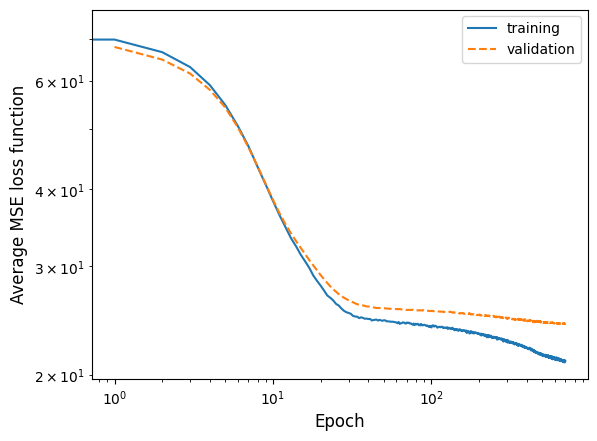

In [221]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='training') #train_value contains the values of the loss function for each epoch of the training set
plt.plot(epoche+1,valid_value,ls='--',label='validation') #valid_value contains the values of the loss function for each epoch of the validation set

plt.legend()
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average MSE loss function", fontsize=12)
plt.loglog()

In [222]:
# get the test data
test_loader = create_dataset('test', SFRD, parameters, batch_size, seed) #test data

# load the best-model and move it to the GPU because I want to use the best set of parameters found over training
model.load_state_dict(torch.load(f_model_1))
model.to(device=device)

#array where to store the true set of parameters and corresponding SFRD sims selected from the files for the test dataset
SFRD_T=np.zeros((int(SFRD.shape[0]*0.75),100), dtype=np.float32)
params_T = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)
#array where to store the network predictions for the parameters
params_N = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)

# loop over batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        # get the number of elements in the batch
        b_size = SFRD_test.shape[0]

        # move data to GPU
        SFRD_test   = SFRD_test.to(device)
        params_test = params_test.to(device)

        # make prediction using network
        params_pred = model(SFRD_test)

        SFRD_T[points:points+b_size,:] = SFRD_test.cpu().numpy()
        params_T[points:points+b_size,:] = params_test.cpu().numpy() #this array has the true values of the parameters used for the SFRD data in the test dataset
        params_N[points:points+b_size, :] = params_pred.cpu().numpy() #this array has the values predicted by the net for the parameters used for the SFRD data in the test dataset

        loss = loss_func_1(params_pred, params_test)

        # compute cumulative loss and number of examples used
        test_loss += loss.item()*b_size
        points    += b_size

# get the average test loss
test_loss /= points

print('test loss = %.3e'%test_loss) #value of the loss function fot the test

#denormalize the parameters

min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
max_params = np.max(parameters, axis=0)

params_T = params_T*(max_params-min_params) + min_params
params_N = params_N*(max_params-min_params) + min_params

test loss = 2.231e+01


<ipython-input-222-96cdaaa3f135>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f_model_1))


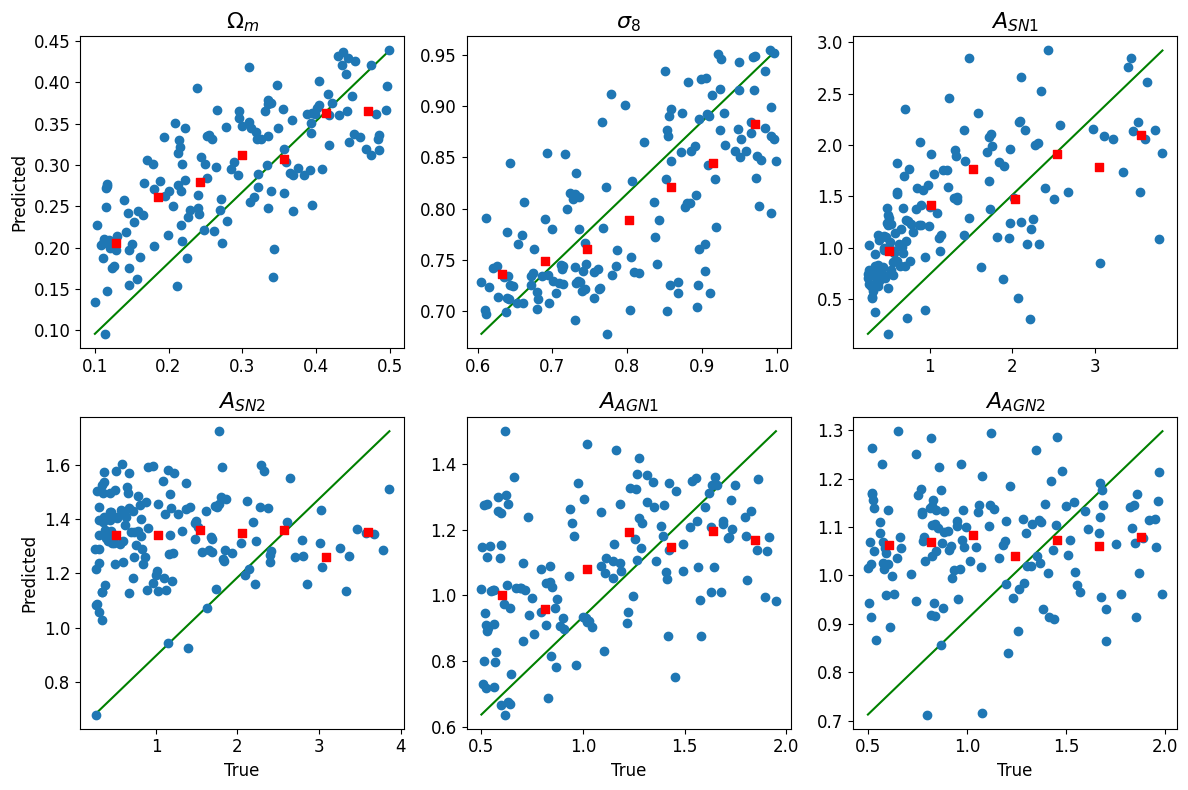

In [223]:
import scipy.stats as stats

bin_edges = []
min_T = np.zeros(6)
max_T = np.zeros(6)
min_N = np.zeros(6)
max_N = np.zeros(6)

for i in range(params_T.shape[1]):
  min_T[i] = np.min(params_T[:,i])
  max_T[i] = np.max(params_T[:,i])
  bin_edges.append(np.linspace(min_T[i], max_T[i], 8))

for i in range(params_N.shape[1]):
  min_N[i] = np.min(params_N[:,i])
  max_N[i] = np.max(params_N[:,i])

fig, axes = plt.subplots(2,3,figsize=(12,8))

title = ['$\Omega_m$', '$\sigma_8$', "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN1}$", "$A_{AGN2}$"]

for i, ax in enumerate(axes.flat):
  ax.scatter(params_T[:,i], params_N[:,i], zorder=1)

  ax.plot([min_T[i],max_T[i]],[min_N[i],max_N[i]], color = 'g', zorder=0)

  mean, bin_edges_x, binnumber = stats.binned_statistic(
      params_T[:,i], params_N[:,i], statistic=np.mean, bins=bin_edges[i])

  ax.scatter(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, marker='s',color='r')


  ax.set_title(title[i], fontsize=16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

for i in range(3):
    axes[1, i].set_xlabel('True', fontsize=12)

for i in range(2):
    axes[i, 0].set_ylabel('Predicted', fontsize=12)

plt.tight_layout()

plt.show()

Anche così la rete non sembra in grado di migliorare la predizione su $A_{SN2}$ e $A_{AGN2}$.

###Uniformare la distribuzioni dei parametri

Facendo un plot triangolare delle distribuzioni dei parametri tramite seaborn si nota che $\Omega_m$ e $\sigma_8$ hanno distribuzione marginale uniforme, mentre gli altri parametri hanno distribuzione esponenziale.

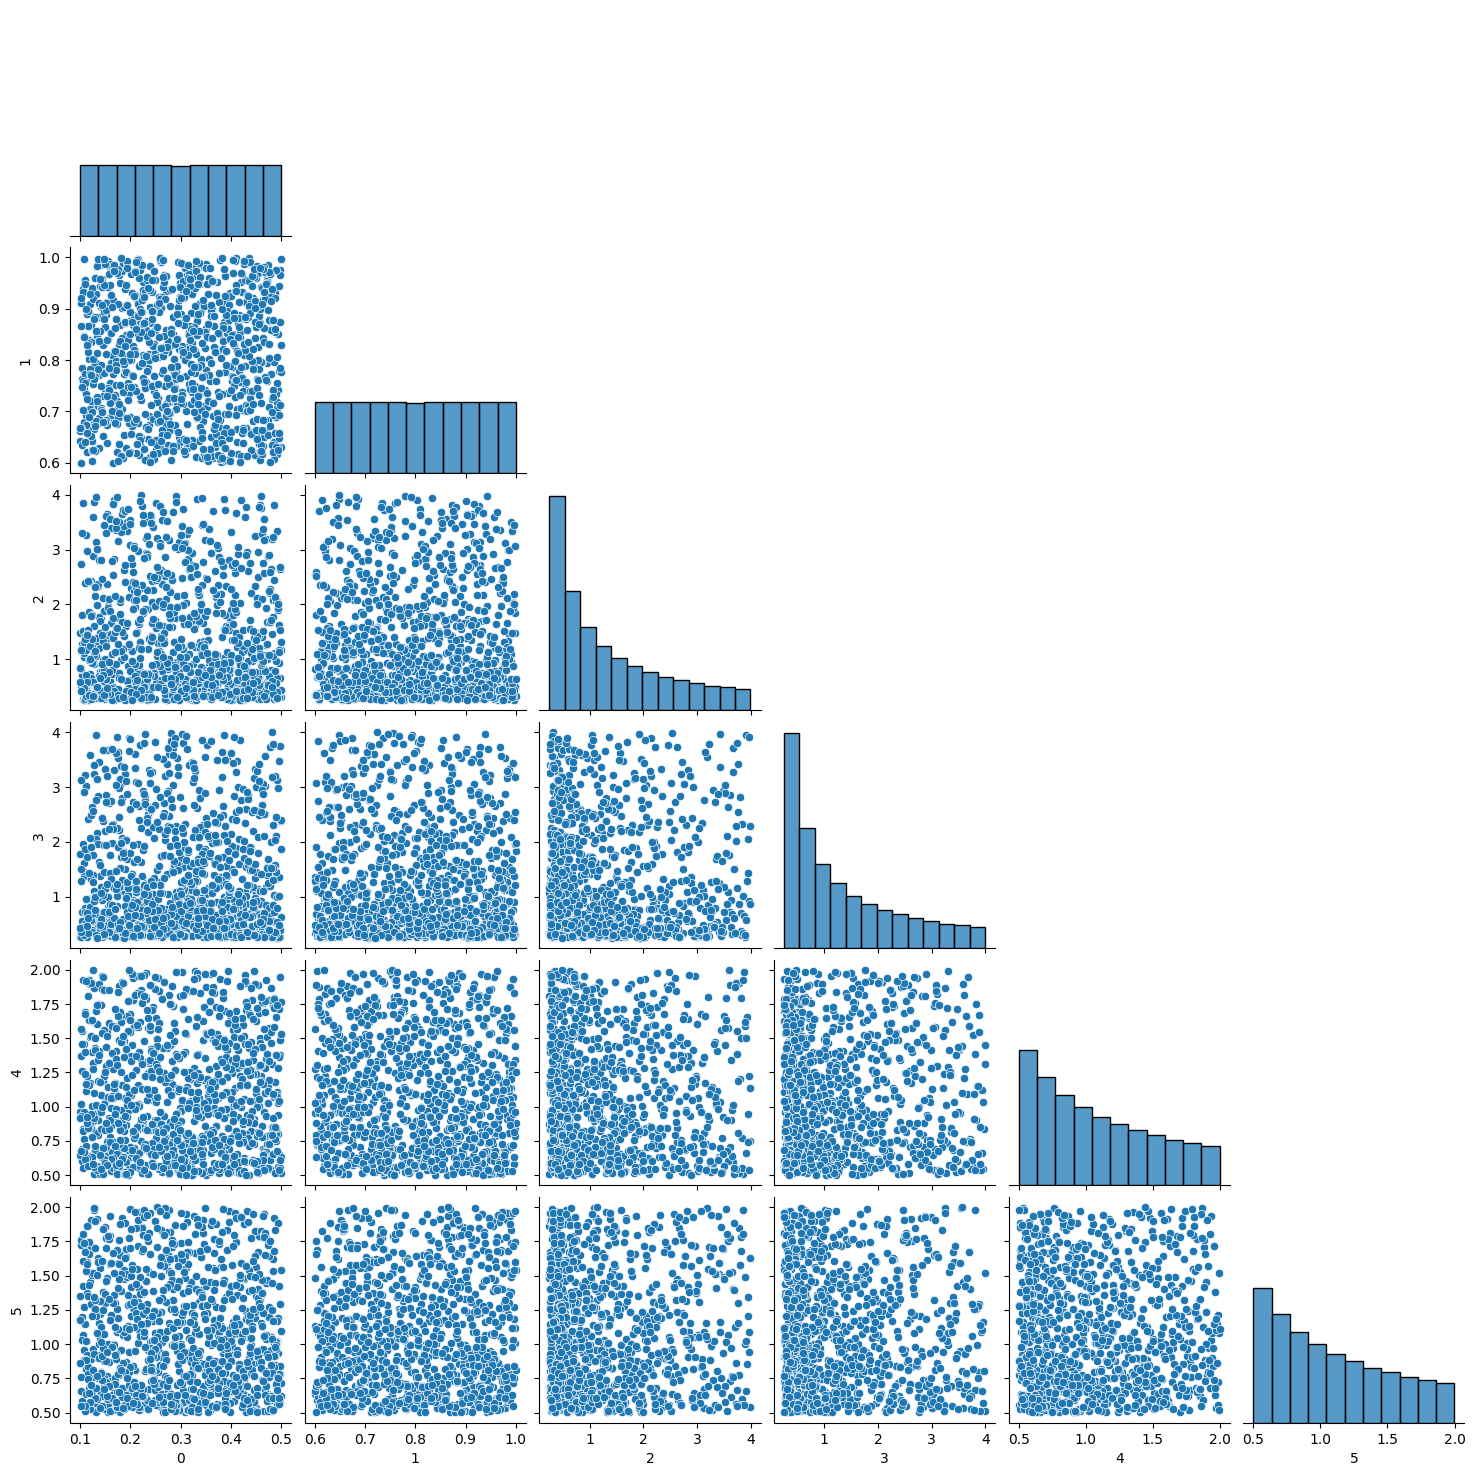

In [224]:
sns.pairplot(pd.DataFrame(parameters), corner=True)
plt.show()

Allora ho ipotizzato che la rete faticasse a predire questi parametri a causa della preponderanza di piccoli valori nel campione fornito. Infatti, come si vede dal grafico seguente, se si confrontano i range dei parametri predetti e quelli dei parametri veri si nota che gli intervalli superiori dei valori predetti sono molto ridotti rispetto a quelli dei rispettivi valori veri, soprattutto per $A_{SN2}$ e $A_{AGN2}$.

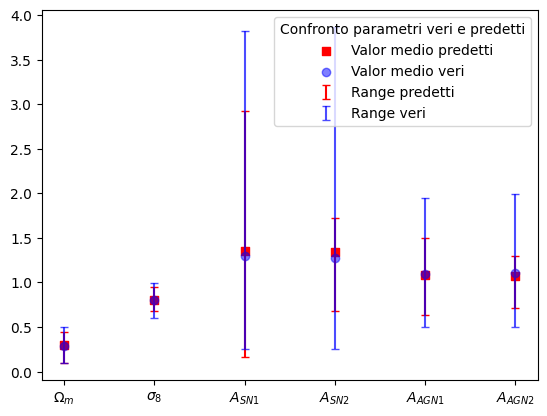

In [225]:
for i in range (6):
  mean_parameters_N = np.mean(params_N, axis = 0)
  mean_parameters_T = np.mean(params_T, axis = 0)

x = np.arange(1,7)
x_labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']
errorbars_N = [mean_parameters_N-min_N, max_N-mean_parameters_N]
errorbars_T = [mean_parameters_T-min_T, max_T-mean_parameters_T]

plt.scatter(x, mean_parameters_N, marker='s', color='r', label = 'Valor medio predetti')
plt.errorbar(x, mean_parameters_N, yerr=errorbars_N, fmt='None', capsize=3, ecolor='r', label='Range predetti')

plt.scatter(x, mean_parameters_T, marker='o', color='b', label = 'Valor medio veri', alpha=0.5)
plt.errorbar(x, mean_parameters_T, yerr=errorbars_T, fmt='None', capsize=3, ecolor='b', label='Range veri', alpha=0.7)

plt.xticks(x, x_labels)

plt.legend(loc = 'upper right', title = 'Confronto parametri veri e predetti', fontsize = '10')
plt.show()

Per cui ho modificato *parameters* lasciando invariate le prime due colonne e prendendo il logaritmo delle ultime quattro in modo che il dataset risultante fosse formato da parametri con una distribuzione più uniforme, nel seguente modo

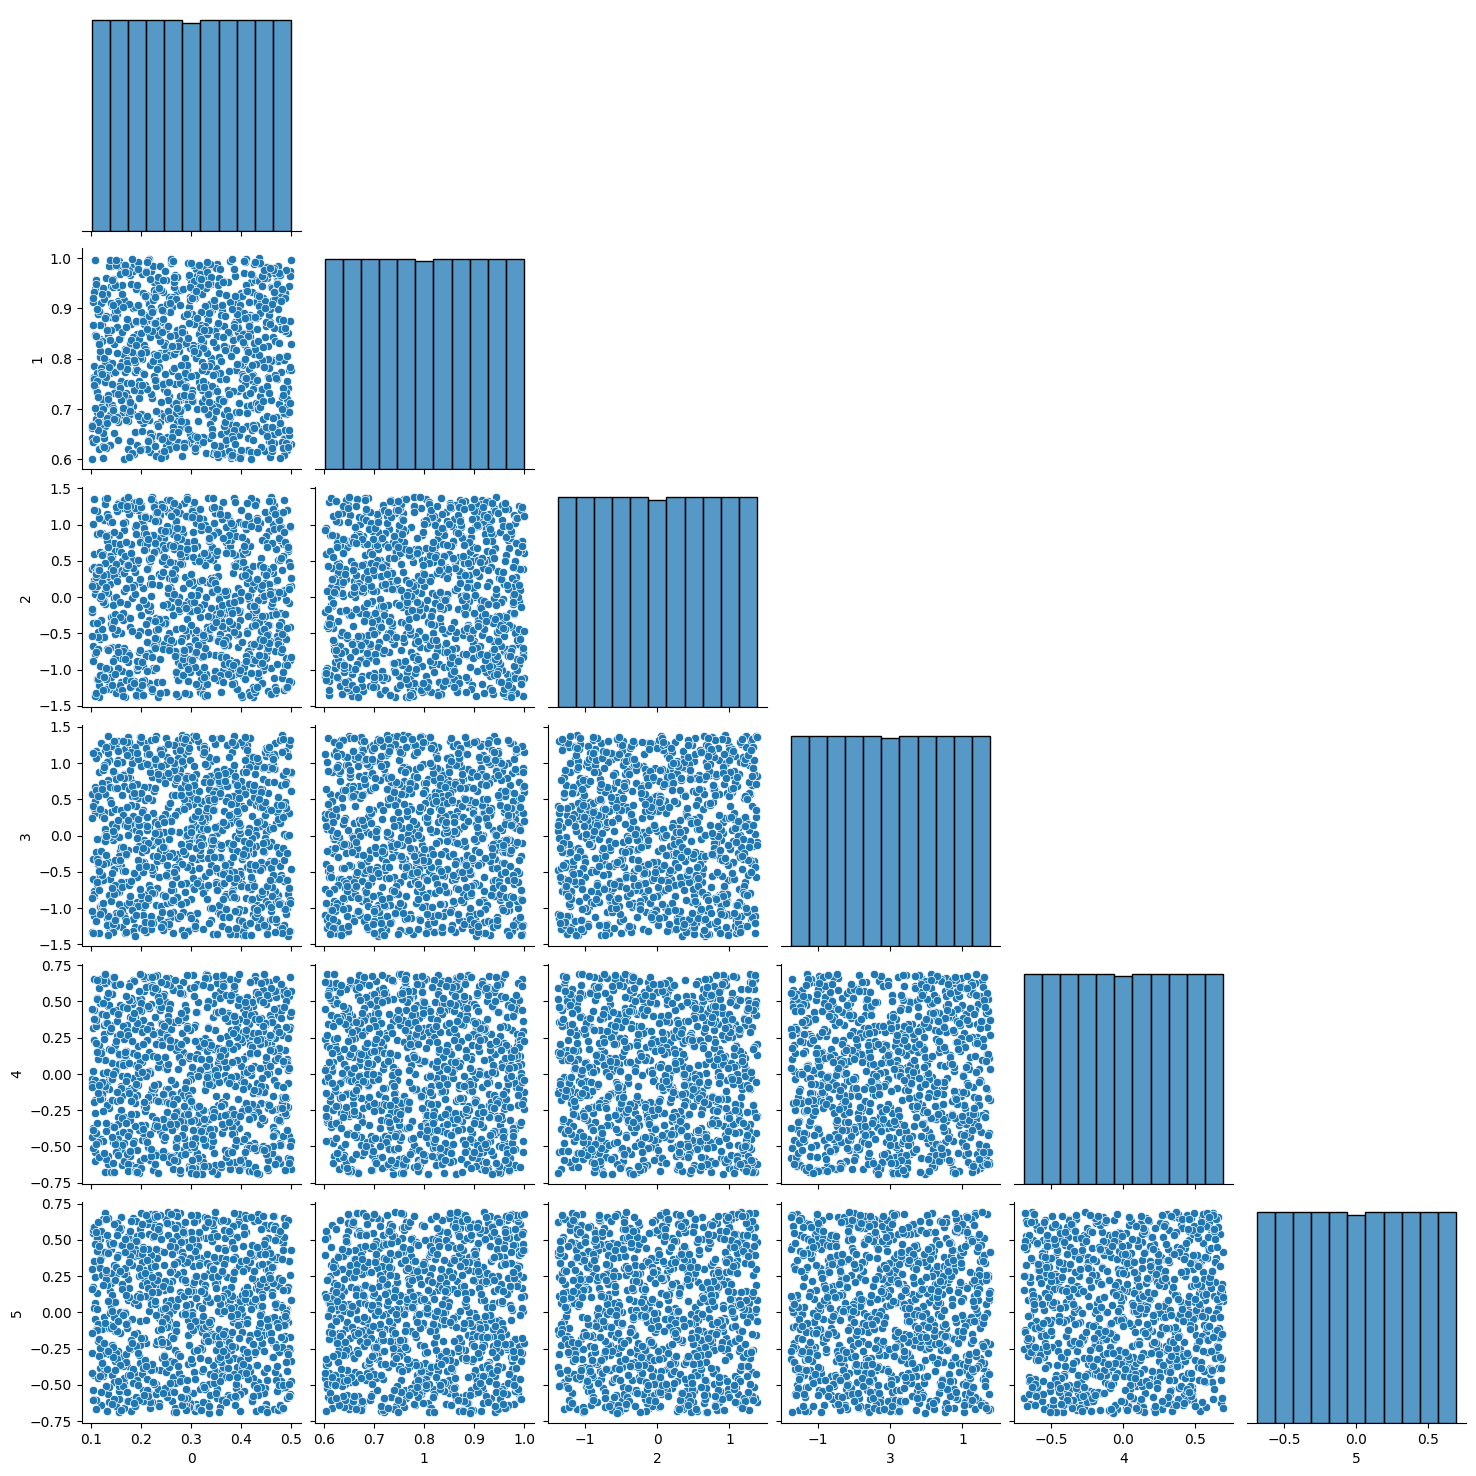

In [226]:
parameters_log = np.zeros([1000, 6])

for i in range(6):
  if i>=2:
    parameters_log[:,i]=np.log(parameters[:,i])
  else:
    parameters_log[:,i]=(parameters[:,i])

sns.pairplot(pd.DataFrame(parameters_log), corner=True)
plt.show()

E allenato la rete usando questo nuovo dataset di parametri.

####Training della rete con nuovo dataset

In [227]:
#hyper-parameters
seed = 2
learning_rate = 2e-5
epochs = 700
hidden_layers = 3
hidden_size = np.array([70, 70, 70])
batch_size = 30
dropout_rate = 0.5
weight_decay = 0.0
patience = 50
stop_criterion = 100
min_valid_loss = 1e10

f_model_2 = 'model_parameters_log.pt'

In [228]:
def create_dataset(mode, SFRD, parameters, batch_size, seed):

  data_set = make_dataset(mode, SFRD, parameters, seed)

  return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)

#create training, validation and test datasets, shuffling them to pick randomly the data to put in each dataset

class make_dataset():
  def __init__(self, mode, SFRD, parameters, seed):
    sims = SFRD.shape[0] #number of simulations is 1000

    #standardization of SFRD over values of z per simulation
    mean = np.tile(np.mean(SFRD, dtype=np.float64, axis=1), (100,1)).T #mean of SFRD values for each simulation
    std = np.tile(np.std(SFRD, dtype=np.float64, axis=1), (100,1)).T #std of SFRD values for each simulation
    SFRD = (SFRD-mean)/std

    #standardization of SFRD over the values of all simulations
    #mean = np.mean(SFRD, dtype=np.float64)
    #std = np.std(SFRD, dtype=np.float64)
    #SFRD = (SFRD-mean)/std

    #normalization of parameters (each one between 0 and 1)
    min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
    max_params = np.max(parameters, axis=0)
    parameters = (parameters - min_params) / (max_params - min_params)

    if   mode=='train':
      size, offset = int(sims*0.70), int(sims*0.00)
    elif mode=='valid':
      size, offset = int(sims*0.15), int(sims*0.70) #offset because the first 70% of data is already in the training data
    elif mode=='test':
      size, offset = int(sims*0.15), int(sims*0.85)
    elif mode=='all':
      size, offset = int(sims*1.00), int(sims*0.00)
    else:
      raise Exception('Wrong name!')

    #shuffling data before splitting into the sets
    np.random.seed(seed)
    idx = np.arange(sims)
    np.random.shuffle(idx)
    idx = idx[offset:offset+size] #depending on the mode you shuffle indexes of the right data set, from the offset to the offset+size of the data set

    self.size = size
    self.input = torch.tensor(SFRD[idx], dtype=torch.float32) #SFRD[idx] has dimensions (size, 100)
    self.output = torch.tensor(parameters[idx], dtype=torch.float32) #parameters[idx] has dimensions (size, 6)

  def __len__(self):
        return self.size

  def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', SFRD, parameters_log, batch_size, seed) #training data
valid_loader = create_dataset('valid', SFRD, parameters_log, batch_size, seed) #validation data

In [229]:
model = nn.Sequential(
            nn.Linear(SFRD.shape[1], hidden_size[0]), #input layer has 100 neurons because each simulation has 100 data
            nn.LeakyReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.LeakyReLU(),
            #nn.Linear(hidden_size[2], hidden_size[3]),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size[2], parameters.shape[1]) #output layer has 6 neurons, one for each parameter
            )

model.to(device=device) #move the model to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('Numero complessivo dei parametri che compongono la rete = %d'%network_total_params)

Numero complessivo dei parametri che compongono la rete = 17436


In [230]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_predicted, y_true):
        return torch.sum((y_true-y_predicted)**2.)

loss_func = loss_function_1()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay) #Adam optimizer for stochastic gradient descent

In [231]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

# Define a scheduler to change the learning rate after number of epochs=patience without improvement
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-10)
current_lr=scheduler.get_last_lr()
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    #training
    train_loss, points = 0.0, 0

    model.train()
    for SFRD_train, params_train in train_loader:  #do a loop over batches

        # get the number of elements in the batch
        b_size =  SFRD_train.shape[0]

        # move data to GPU
        SFRD_train   = SFRD_train.to(device)
        params_train = params_train.to(device)

        # compute the value predicted by the network by linear combination with the current set of parameters
        params_pred  = model(SFRD_train)

        # compute loss
        loss = loss_func(params_pred, params_train)

        # compute cumulative loss over the elements in the batch and number of examples used
        train_loss += loss.item()*b_size #.item() returns tensors with one element as standard python numbers
        points     += b_size #at the end of the iteration is the size of the training set because it sums the elements in the batches

        optimizer.zero_grad() # set gradient to zero to compute the gradient on the next set of improved parameters
        loss.backward() #compute the gradient of the loss function with respect to the parameters
        optimizer.step() #improve the parameters according to the learning rate

    # get the average training loss over the batches for this epoch
    train_loss /= points
    train_value[epoch]=train_loss #array with the improvements of the loss function over the epochs

    # do validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader: # do a loop over batches
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the number of elements in the batch
            b_size = SFRD_val.shape[0]

            # move data to the GPU
            SFRD_val   = SFRD_val.to(device)
            params_val = params_val.to(device)

            # compute prediction by the network
            params_pred = model(SFRD_val)

            # compute loss
            loss = loss_func(params_pred, params_val)

            # compute cumulative loss over the elements in the batch and number of examples used
            valid_loss += loss.item()*b_size
            points     += b_size

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the learning rate if needed

    if current_lr!=scheduler.get_last_lr():
        print('Learning rate updated to', scheduler.get_last_lr())
        current_lr=scheduler.get_last_lr()

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e'%(epoch, train_loss, valid_loss), end='') #prints results for every epoch on both training and validation sets
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model_2) #saves in the file f_model_parameters just the states of the model that improve learning
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model so far)')
    else:
        print('')
    #stop training if there is no improvement after number of epochs=stop_criterion
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not improved after ',stop_criterion,' epochs')
        print('Last Learning Rate', scheduler.get_last_lr())
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

000 1.151e+02 1.076e+02 (best-model so far)
001 1.085e+02 1.018e+02 (best-model so far)
002 1.028e+02 9.607e+01 (best-model so far)
003 9.691e+01 9.027e+01 (best-model so far)
004 9.059e+01 8.435e+01 (best-model so far)
005 8.425e+01 7.819e+01 (best-model so far)
006 7.766e+01 7.197e+01 (best-model so far)
007 7.117e+01 6.609e+01 (best-model so far)
008 6.470e+01 6.068e+01 (best-model so far)
009 5.933e+01 5.588e+01 (best-model so far)
010 5.416e+01 5.172e+01 (best-model so far)
011 5.009e+01 4.819e+01 (best-model so far)
012 4.634e+01 4.528e+01 (best-model so far)
013 4.332e+01 4.295e+01 (best-model so far)
014 4.076e+01 4.110e+01 (best-model so far)
015 3.876e+01 3.963e+01 (best-model so far)
016 3.701e+01 3.847e+01 (best-model so far)
017 3.565e+01 3.751e+01 (best-model so far)
018 3.461e+01 3.670e+01 (best-model so far)
019 3.361e+01 3.598e+01 (best-model so far)
020 3.277e+01 3.532e+01 (best-model so far)
021 3.201e+01 3.470e+01 (best-model so far)
022 3.128e+01 3.413e+01 (best-mo

[]

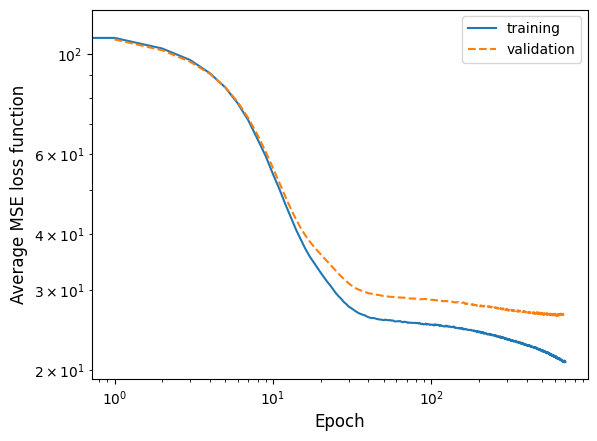

In [232]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='training') #train_value contains the values of the loss function for each epoch of the training set
plt.plot(epoche+1,valid_value,ls='--',label='validation') #valid_value contains the values of the loss function for each epoch of the validation set

plt.legend()
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average MSE loss function", fontsize=12)
plt.loglog()

In [233]:
# get the test data
test_loader = create_dataset('test', SFRD, parameters_log, batch_size, seed) #test data

# load the best-model and move it to the GPU because I want to use the best set of parameters found over training
model.load_state_dict(torch.load(f_model_2))
model.to(device=device)

#array where to store the true set of parameters and corresponding SFRD sims selected from the files for the test dataset
SFRD_T=np.zeros((int(SFRD.shape[0]*0.75),100), dtype=np.float32)
params_T = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)
#array where to store the network predictions for the parameters
params_N = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)

# loop over batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        # get the number of elements in the batch
        b_size = SFRD_test.shape[0]

        # move data to GPU
        SFRD_test   = SFRD_test.to(device)
        params_test = params_test.to(device)

        # make prediction using network
        params_pred = model(SFRD_test)

        SFRD_T[points:points+b_size, :] = SFRD_test.cpu().numpy()
        params_T[points:points+b_size, :] = params_test.cpu().numpy() #this array has the true values of the parameters used for the SFRD data in the test dataset
        params_N[points:points+b_size, :] = params_pred.cpu().numpy() #this array has the values predicted by the net for the parameters used for the SFRD data in the test dataset

        loss = loss_func(params_pred, params_test)

        # compute cumulative loss and number of examples used
        test_loss += loss.item()*b_size
        points    += b_size

# get the average test loss
test_loss /= points

print('test loss = %.3e'%test_loss) #value of the loss function fot the test

#denormalize the parameters

min_params = np.min(parameters_log, axis=0) #min and max for each of the six params over the simulations
max_params = np.max(parameters_log, axis=0)

params_T = params_T*(max_params-min_params) + min_params
params_N = params_N*(max_params-min_params) + min_params

test loss = 2.450e+01


<ipython-input-233-1a422452fcec>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f_model_2))


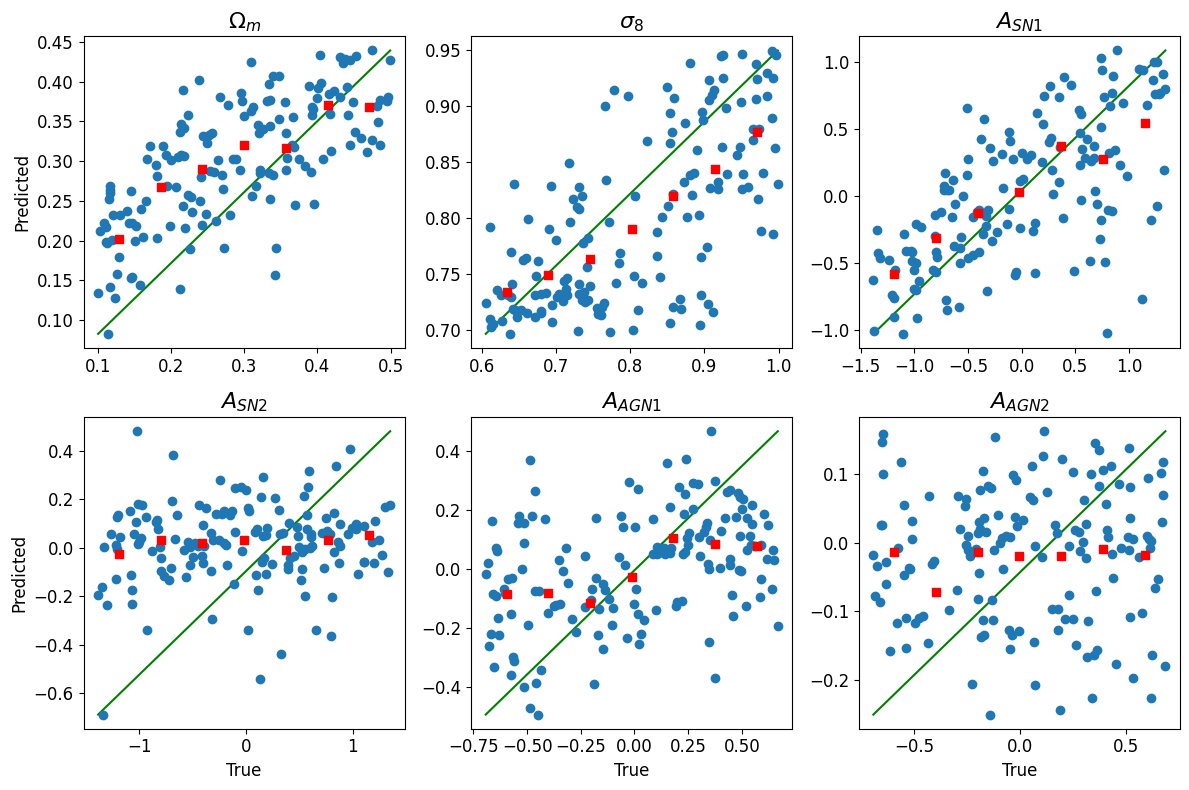

In [234]:
import scipy.stats as stats

bin_edges = []
min_T = np.zeros(6)
max_T = np.zeros(6)
min_N = np.zeros(6)
max_N = np.zeros(6)

for i in range(params_T.shape[1]):
  min_T[i] = np.min(params_T[:,i])
  max_T[i] = np.max(params_T[:,i])
  bin_edges.append(np.linspace(min_T[i], max_T[i], 8))

for i in range(params_N.shape[1]):
  min_N[i] = np.min(params_N[:,i])
  max_N[i] = np.max(params_N[:,i])

fig, axes = plt.subplots(2,3,figsize=(12,8))

title = ['$\Omega_m$', '$\sigma_8$', "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN1}$", "$A_{AGN2}$"]

for i, ax in enumerate(axes.flat):
  ax.scatter(params_T[:,i], params_N[:,i], zorder=1)

  ax.plot([min_T[i],max_T[i]],[min_N[i],max_N[i]], color = 'g', zorder=0)

  mean, bin_edges_x, binnumber = stats.binned_statistic(
      params_T[:,i], params_N[:,i], statistic=np.mean, bins=bin_edges[i])

  ax.scatter(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, marker='s',color='r')


  ax.set_title(title[i], fontsize=16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

for i in range(3):
    axes[1, i].set_xlabel('True', fontsize=12)

for i in range(2):
    axes[i, 0].set_ylabel('Predicted', fontsize=12)

plt.tight_layout()

plt.show()

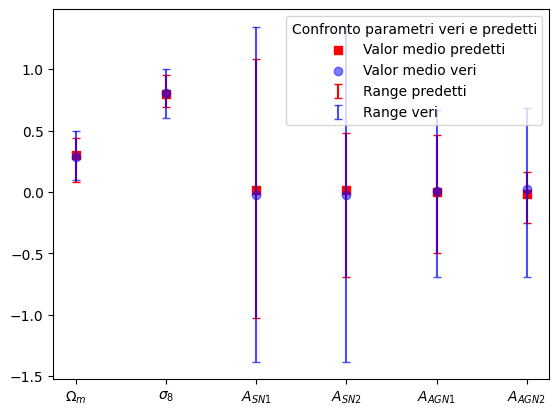

In [235]:
for i in range (6):
  mean_parameters_N = np.mean(params_N, axis = 0)
  mean_parameters_T = np.mean(params_T, axis = 0)

x = np.arange(1,7)
x_labels = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']
errorbars_N = [mean_parameters_N-min_N, max_N-mean_parameters_N]
errorbars_T = [mean_parameters_T-min_T, max_T-mean_parameters_T]

plt.scatter(x, mean_parameters_N, marker='s', color='r', label = 'Valor medio predetti')
plt.errorbar(x, mean_parameters_N, yerr=errorbars_N, fmt='None', capsize=3, ecolor='r', label='Range predetti')

plt.scatter(x, mean_parameters_T, marker='o', color='b', label = 'Valor medio veri', alpha=0.5)
plt.errorbar(x, mean_parameters_T, yerr=errorbars_T, fmt='None', capsize=3, ecolor='b', label='Range veri', alpha=0.7)

plt.xticks(x, x_labels)

plt.legend(loc = 'upper right', title = 'Confronto parametri veri e predetti', fontsize = '10')
plt.show()

Il problema non viene risolto ma si notano dei miglioramenti:


*   Nella predizione dei valori di $A_{SN1}$: si nota un maggiore allineamento con la bisettrice nel primo grafico e una migliore sovrapposizione dei range nel secondo grafico
*   Una migliore distribuzione dei punti nel grafico corrispondente al parametro $A_{SN2}$ sopra e sotto la bisettrice, seppur non allineati come ci si aspetterebbe



###Predizione separata di $A_{SN2}$ e $A_{AGN2}$

Come ultimo tentativo ho provato ad allenare separatamente un'altra rete usando solo i valori di $A_{SN2}$ e $A_{AGN2}$, ottenendo sempre una pessima predizione dei due parametri. Da questo posso dedurre che il cattivo apprendimento della rete non è causato da un'eccessiva importanza attribuita ai parametri che vengono predetti correttamente (difatti con una loss function opportunamente pesata la performance della rete non migliora), ma sembra dovuto ad un'intrinseca incapacità della rete ad imparare a stimare i valori di $A_{SN2}$ e $A_{AGN2}$ a partire dal dataset di misure di $SFRD(z)$ fornito.

Una possibile spiegazione potrebbe essere che questi parametri siano inutili alla descrizione del modello e di conseguenza la rete non è in grado di trovare una relazione tra le misure di $SFRD(z)$ e i valori di questi parametri, che sembrano non influenzare le simulazioni svolte come invece fanno gli altri 4 parametri ipotizzati nella descrizione del modello.

####Training di una rete che predice due parametri

In [236]:
two_parameters = np.zeros((1000, 2))
two_parameters[:,0] = parameters[:,3]
two_parameters[:,1] = parameters[:,5]

Riduco numero di epoche e numero di hidden layers

In [237]:
#hyper-parameters
seed = 2
learning_rate = 2e-5
epochs = 50
hidden_layers = 2
hidden_size = np.array([70, 70])
batch_size = 30
dropout_rate = 0.5
weight_decay = 0.0
patience = 50
stop_criterion = 100
min_valid_loss = 1e10

f_model_3 = 'model_two_parameters.pt'

In [238]:
def create_dataset(mode, SFRD, parameters, batch_size, seed):

  data_set = make_dataset(mode, SFRD, parameters, seed)

  return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)

#create training, validation and test datasets, shuffling them to pick randomly the data to put in each dataset

class make_dataset():
  def __init__(self, mode, SFRD, parameters, seed):
    sims = SFRD.shape[0] #number of simulations is 1000

    #standardization of SFRD over values of z per simulation
    mean = np.tile(np.mean(SFRD, dtype=np.float64, axis=1), (100,1)).T #mean of SFRD values for each simulation
    std = np.tile(np.std(SFRD, dtype=np.float64, axis=1), (100,1)).T #std of SFRD values for each simulation
    SFRD = (SFRD-mean)/std

    #standardization of SFRD over the values of all simulations
    #mean = np.mean(SFRD, dtype=np.float64)
    #std = np.std(SFRD, dtype=np.float64)
    #SFRD = (SFRD-mean)/std

    #normalization of parameters (each one between 0 and 1)
    min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
    max_params = np.max(parameters, axis=0)
    parameters = (parameters - min_params) / (max_params - min_params)

    if   mode=='train':
      size, offset = int(sims*0.70), int(sims*0.00)
    elif mode=='valid':
      size, offset = int(sims*0.15), int(sims*0.70) #offset because the first 70% of data is already in the training data
    elif mode=='test':
      size, offset = int(sims*0.15), int(sims*0.85)
    elif mode=='all':
      size, offset = int(sims*1.00), int(sims*0.00)
    else:
      raise Exception('Wrong name!')

    #shuffling data before splitting into the sets
    np.random.seed(seed)
    idx = np.arange(sims)
    np.random.shuffle(idx)
    idx = idx[offset:offset+size] #depending on the mode you shuffle indexes of the right data set, from the offset to the offset+size of the data set

    self.size = size
    self.input = torch.tensor(SFRD[idx], dtype=torch.float32) #SFRD[idx] has dimensions (size, 100)
    self.output = torch.tensor(parameters[idx], dtype=torch.float32) #parameters[idx] has dimensions (size, 6)

  def __len__(self):
        return self.size

  def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', SFRD, two_parameters, batch_size, seed) #training data
valid_loader = create_dataset('valid', SFRD, two_parameters, batch_size, seed) #validation data

In [239]:
model = nn.Sequential(
            nn.Linear(SFRD.shape[1], hidden_size[0]), #input layer has 100 neurons because each simulation has 100 data
            nn.LeakyReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.LeakyReLU(),
            #nn.Linear(hidden_size[1], hidden_size[2]),
            #nn.LeakyReLU(),
            #nn.Linear(hidden_size[2], hidden_size[3]),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size[1], two_parameters.shape[1]) #output layer has 6 neurons, one for each parameter
            )

model.to(device=device) #move the model to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('Numero complessivo dei parametri che compongono la rete = %d'%network_total_params)

Numero complessivo dei parametri che compongono la rete = 12182


In [240]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_predicted, y_true):
        return torch.sum((y_true-y_predicted)**2.) #MSE loss function
        #return torch.log(torch.sum((y_true-y_predicted)**2.)) #logarithmic loss function

loss_func = loss_function()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay) #Adam optimizer for stochastic gradient descent

In [241]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

# Define a scheduler to change the learning rate after number of epochs=patience without improvement
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-10)
current_lr=scheduler.get_last_lr()
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    #training
    train_loss, points = 0.0, 0

    model.train()
    for SFRD_train, params_train in train_loader:  #do a loop over batches

        # get the number of elements in the batch
        b_size =  SFRD_train.shape[0]

        # move data to GPU
        SFRD_train   = SFRD_train.to(device)
        params_train = params_train.to(device)

        # compute the value predicted by the network by linear combination with the current set of parameters
        params_pred  = model(SFRD_train)

        # compute loss
        loss = loss_func(params_pred, params_train)

        # compute cumulative loss over the elements in the batch and number of examples used
        train_loss += loss.item()*b_size #.item() returns tensors with one element as standard python numbers
        points     += b_size #at the end of the iteration is the size of the training set because it sums the elements in the batches

        optimizer.zero_grad() # set gradient to zero to compute the gradient on the next set of improved parameters
        loss.backward() #compute the gradient of the loss function with respect to the parameters
        optimizer.step() #improve the parameters according to the learning rate

    # get the average training loss over the batches for this epoch
    train_loss /= points
    train_value[epoch]=train_loss #array with the improvements of the loss function over the epochs

    # do validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader: # do a loop over batches
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the number of elements in the batch
            b_size = SFRD_val.shape[0]

            # move data to the GPU
            SFRD_val   = SFRD_val.to(device)
            params_val = params_val.to(device)

            # compute prediction by the network
            params_pred = model(SFRD_val)

            # compute loss
            loss = loss_func(params_pred, params_val)

            # compute cumulative loss over the elements in the batch and number of examples used
            valid_loss += loss.item()*b_size
            points     += b_size

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the learning rate if needed

    if current_lr!=scheduler.get_last_lr():
        print('Learning rate updated to', scheduler.get_last_lr())
        current_lr=scheduler.get_last_lr()

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e  %.3e'%(epoch, train_loss, valid_loss, valid_loss-train_loss), end='') #prints results for every epoch on both training and validation sets
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model_3) #saves in the file f_model_parameters just the states of the model that improve learning
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model so far)')
    else:
        print('')
    #stop training if there is no improvement after number of epochs=stop_criterion
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not improved after ',stop_criterion,' epochs')
        print('Last Learning Rate', scheduler.get_last_lr())
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

000 7.760e+00 7.033e+00  -7.271e-01 (best-model so far)
001 6.878e+00 6.386e+00  -4.917e-01 (best-model so far)
002 6.286e+00 5.910e+00  -3.764e-01 (best-model so far)
003 5.832e+00 5.575e+00  -2.566e-01 (best-model so far)
004 5.463e+00 5.355e+00  -1.077e-01 (best-model so far)
005 5.246e+00 5.211e+00  -3.454e-02 (best-model so far)
006 5.113e+00 5.119e+00  6.685e-03 (best-model so far)
007 4.987e+00 5.061e+00  7.407e-02 (best-model so far)
008 4.902e+00 5.022e+00  1.201e-01 (best-model so far)
009 4.892e+00 4.994e+00  1.022e-01 (best-model so far)
010 4.820e+00 4.972e+00  1.522e-01 (best-model so far)
011 4.814e+00 4.956e+00  1.419e-01 (best-model so far)
012 4.799e+00 4.943e+00  1.448e-01 (best-model so far)
013 4.782e+00 4.932e+00  1.498e-01 (best-model so far)
014 4.773e+00 4.924e+00  1.507e-01 (best-model so far)
015 4.743e+00 4.919e+00  1.760e-01 (best-model so far)
016 4.731e+00 4.911e+00  1.797e-01 (best-model so far)
017 4.741e+00 4.908e+00  1.664e-01 (best-model so far)
018 

[]

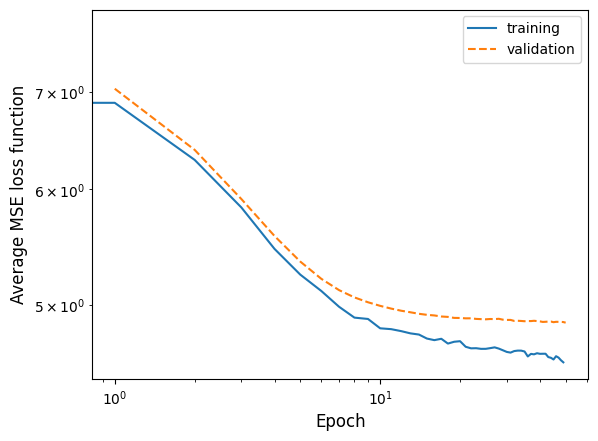

In [242]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='training') #train_value contains the values of the loss function for each epoch of the training set
plt.plot(epoche+1,valid_value,ls='--',label='validation') #valid_value contains the values of the loss function for each epoch of the validation set

plt.legend()
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average MSE loss function", fontsize=12)
plt.loglog()

In [243]:
# get the test data
test_loader = create_dataset('test', SFRD, two_parameters, batch_size, seed) #test data

# load the best-model and move it to the GPU because I want to use the best set of parameters found over training
model.load_state_dict(torch.load(f_model_3))
model.to(device=device)

#array where to store the true set of parameters and corresponding SFRD sims selected from the files for the test dataset
SFRD_T=np.zeros((int(SFRD.shape[0]*0.75),100), dtype=np.float32)
params_T = np.zeros((int(SFRD.shape[0]*0.15),2), dtype=np.float32)
#array where to store the network predictions for the parameters
params_N = np.zeros((int(SFRD.shape[0]*0.15),2), dtype=np.float32)

# loop over batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        # get the number of elements in the batch
        b_size = SFRD_test.shape[0]

        # move data to GPU
        SFRD_test   = SFRD_test.to(device)
        params_test = params_test.to(device)

        # make prediction using network
        params_pred = model(SFRD_test)

        SFRD_T[points:points+b_size, :] = SFRD_test.cpu().numpy()
        params_T[points:points+b_size, :] = params_test.cpu().numpy() #this array has the true values of the parameters used for the SFRD data in the test dataset
        params_N[points:points+b_size, :] = params_pred.cpu().numpy() #this array has the values predicted by the net for the parameters used for the SFRD data in the test dataset

        loss = loss_func(params_pred, params_test)

        # compute cumulative loss and number of examples used
        test_loss += loss.item()*b_size
        points    += b_size

# get the average test loss
test_loss /= points

print('test loss = %.3e'%test_loss) #value of the loss function fot the test

#denormalize the parameters

min_params = np.min(two_parameters, axis=0) #min and max for each of the six params over the simulations
max_params = np.max(two_parameters, axis=0)

params_T = params_T*(max_params-min_params) + min_params
params_N = params_N*(max_params-min_params) + min_params

test loss = 4.287e+00


<ipython-input-243-534b3da3a99a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f_model_3))


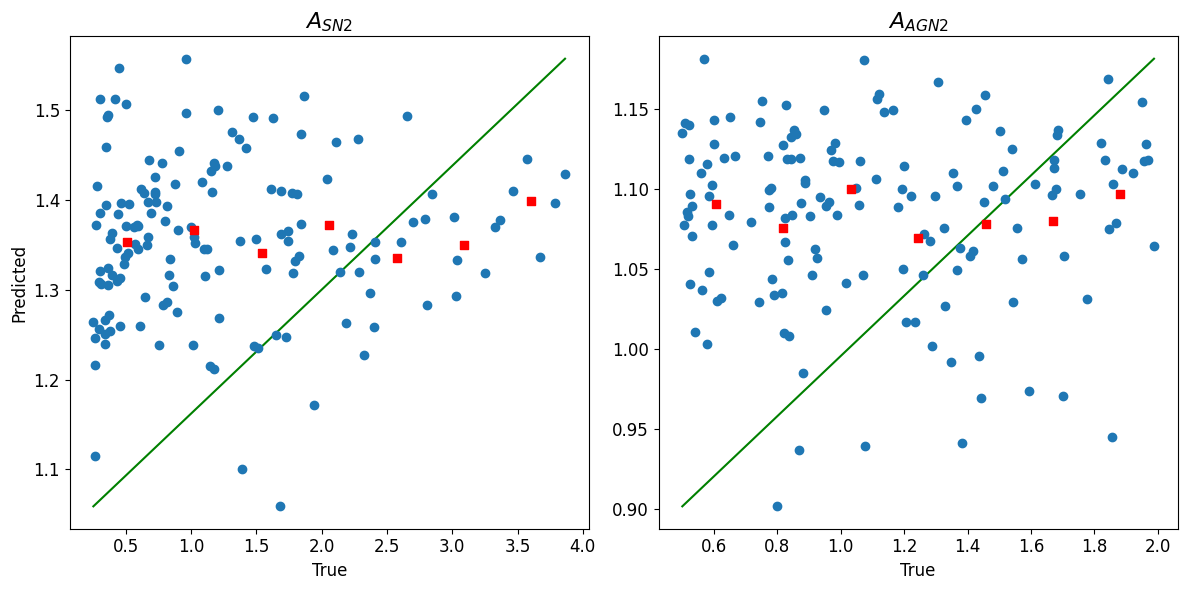

In [244]:
import scipy.stats as stats

bin_edges = []
min_T = np.zeros(2)
max_T = np.zeros(2)
min_N = np.zeros(2)
max_N = np.zeros(2)

for i in range(params_T.shape[1]):
  min_T[i] = np.min(params_T[:,i])
  max_T[i] = np.max(params_T[:,i])
  bin_edges.append(np.linspace(min_T[i], max_T[i], 8))

for i in range(params_N.shape[1]):
  min_N[i] = np.min(params_N[:,i])
  max_N[i] = np.max(params_N[:,i])

fig, axes = plt.subplots(1,2,figsize=(12,6))

title = ["$A_{SN2}$", "$A_{AGN2}$"]

for i, ax in enumerate(axes):
  ax.scatter(params_T[:,i], params_N[:,i], zorder=1)

  ax.plot([min_T[i],max_T[i]],[min_N[i],max_N[i]], color = 'g', zorder=0)

  mean, bin_edges_x, binnumber = stats.binned_statistic(
      params_T[:,i], params_N[:,i], statistic=np.mean, bins=bin_edges[i])

  ax.scatter(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, marker='s',color='r')


  ax.set_title(title[i], fontsize=16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

for i in range(2):
    axes[i].set_xlabel('True', fontsize=12)

axes[0].set_ylabel('Predicted', fontsize=12)

plt.tight_layout()

plt.show()

##Stima degli errori
Ora la rete viene modificata in modo che sia in grado di predire gli errori che commette sui parametri stimati.
Le uniche modifiche da fare sono al numero di neuroni di output che da 6 diventano 12 poiché a ciascun parametro è associata la predizione del suo errore e alla loss function che diventa della forma:
$$\sum_{p \in {\rm params}} \sum_{ i \in {\rm batch}} \left( (p_i^{true}-p_i^{pred})^2 + ((p_i^{true}-p_i^{pred})^2-\sigma_{p,i}^2)^2\right)$$

In questo modo per minimizzare la loss function la rete deve anche minimizzare il termine aggiuntivo e di conseguenza imparare a predire correttamente gli errori su ciscun parametro.

Siccome i parametri da stimare ora sono 12 i neuroni in ciascun layer sono stati aumentati a 80.

In [245]:
#hyper-parameters
seed = 2
learning_rate = 2e-5
epochs = 700
hidden_layers = 3
hidden_size = np.array([80, 80, 80])
batch_size = 30
dropout_rate = 0.5
weight_decay = 0.0
patience = 50
stop_criterion = 100
min_valid_loss = 1e10

f_model = 'model_parameters_sigma.pt'

In [246]:
def create_dataset(mode, SFRD, parameters, batch_size, seed):

  data_set = make_dataset(mode, SFRD, parameters, seed)

  return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)

#create training, validation and test datasets, shuffling them to pick randomly the data to put in each dataset

class make_dataset():
  def __init__(self, mode, SFRD, parameters, seed):
    sims = SFRD.shape[0] #number of simulations is 1000

    #standardization of SFRD over values of z per simulation
    mean = np.tile(np.mean(SFRD, dtype=np.float64, axis=1), (100,1)).T #mean of SFRD values for each simulation
    std = np.tile(np.std(SFRD, dtype=np.float64, axis=1), (100,1)).T #std of SFRD values for each simulation
    SFRD = (SFRD-mean)/std

    #standardization of SFRD over the values of all simulations
    #mean = np.mean(SFRD, dtype=np.float64)
    #std = np.std(SFRD, dtype=np.float64)
    #SFRD = (SFRD-mean)/std

    #normalization of parameters (each one between 0 and 1)
    min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
    max_params = np.max(parameters, axis=0)
    parameters = (parameters - min_params) / (max_params - min_params)

    if   mode=='train':
      size, offset = int(sims*0.70), int(sims*0.00)
    elif mode=='valid':
      size, offset = int(sims*0.15), int(sims*0.70) #offset because the first 70% of data is already in the training data
    elif mode=='test':
      size, offset = int(sims*0.15), int(sims*0.85)
    elif mode=='all':
      size, offset = int(sims*1.00), int(sims*0.00)
    else:
      raise Exception('Wrong name!')

    #shuffling data before splitting into the sets
    np.random.seed(seed)
    idx = np.arange(sims)
    np.random.shuffle(idx)
    idx = idx[offset:offset+size] #depending on the mode you shuffle indexes of the right data set, from the offset to the offset+size of the data set

    self.size = size
    self.input = torch.tensor(SFRD[idx], dtype=torch.float32) #SFRD[idx] has dimensions (size, 100)
    self.output = torch.tensor(parameters[idx], dtype=torch.float32) #parameters[idx] has dimensions (size, 6)

  def __len__(self):
        return self.size

  def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', SFRD, parameters, batch_size, seed) #training data
valid_loader = create_dataset('valid', SFRD, parameters, batch_size, seed) #validation data

In [247]:
model = nn.Sequential(
            nn.Linear(SFRD.shape[1], hidden_size[0]), #input layer has 100 neurons because each simulation has 100 data
            nn.LeakyReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.LeakyReLU(),
            #nn.Linear(hidden_size[2], hidden_size[3]),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size[2], 2*parameters.shape[1]) #output layer has 6 neurons, one for each parameter
            )

model.to(device=device) #move the model to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the network = %d'%network_total_params)

total number of parameters in the network = 22012


###Definizione della nuova loss function

In [248]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_predicted, sigma_predicted, y_true):
        return torch.sum((y_true-y_predicted)**2.+((y_true-y_predicted)**2. - sigma_predicted**2.)**2.) #MSE loss function


loss_func = loss_function()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay) #Adam optimizer for stochastic gradient descent

In [249]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

# Define a scheduler to change the learning rate after number of epochs=patience without improvement
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-10)
current_lr=scheduler.get_last_lr()
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    #training
    train_loss, points = 0.0, 0

    model.train()
    for SFRD_train, params_train in train_loader:  #do a loop over batches

        # get the number of elements in the batch
        b_size =  SFRD_train.shape[0]

        # move data to GPU
        SFRD_train   = SFRD_train.to(device)
        params_train = params_train.to(device)

        # compute the value predicted by the network by linear combination with the current set of parameters
        params_sigma_pred  = model(SFRD_train)

        params_pred = params_sigma_pred[:, :12 // 2]
        sigma_pred = params_sigma_pred[:, 12 // 2:]

        # compute loss
        loss = loss_func(params_pred, sigma_pred, params_train)

        # compute cumulative loss over the elements in the batch and number of examples used
        train_loss += loss.item()*b_size #.item() returns tensors with one element as standard python numbers
        points     += b_size #at the end of the iteration is the size of the training set because it sums the elements in the batches

        optimizer.zero_grad() # set gradient to zero to compute the gradient on the next set of improved parameters
        loss.backward() #compute the gradient of the loss function with respect to the parameters
        optimizer.step() #improve the parameters according to the learning rate

    # get the average training loss over the batches for this epoch
    train_loss /= points
    train_value[epoch]=train_loss #array with the improvements of the loss function over the epochs

    # do validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader: # do a loop over batches
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the number of elements in the batch
            b_size = SFRD_val.shape[0]

            # move data to the GPU
            SFRD_val   = SFRD_val.to(device)
            params_val = params_val.to(device)

            # compute prediction by the network
            params_sigma_pred  = model(SFRD_val)

            params_pred = params_sigma_pred[:, :12 // 2]
            sigma_pred = params_sigma_pred[:, 12 // 2:]

            # compute loss
            loss = loss_func(params_pred, sigma_pred, params_val)

            # compute cumulative loss over the elements in the batch and number of examples used
            valid_loss += loss.item()*b_size
            points     += b_size

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the learning rate if needed

    if current_lr!=scheduler.get_last_lr():
        print('Learning rate updated to', scheduler.get_last_lr())
        current_lr=scheduler.get_last_lr()

    # save model if it has a lower validation loss
    print('%03d %.3e %.3e'%(epoch, train_loss, valid_loss), end='') #prints results for every epoch on both training and validation sets
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model) #saves in the file f_model_parameters just the states of the model that improve learning
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model so far)')
    else:
        print('')
    #stop training if there is no improvement after number of epochs=stop_criterion
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not improved after ',stop_criterion,' epochs')
        print('Last Learning Rate', scheduler.get_last_lr())
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

000 7.228e+01 7.203e+01 (best-model so far)
001 6.881e+01 6.865e+01 (best-model so far)
002 6.549e+01 6.533e+01 (best-model so far)
003 6.218e+01 6.195e+01 (best-model so far)
004 5.894e+01 5.843e+01 (best-model so far)
005 5.527e+01 5.471e+01 (best-model so far)
006 5.165e+01 5.074e+01 (best-model so far)
007 4.773e+01 4.658e+01 (best-model so far)
008 4.370e+01 4.227e+01 (best-model so far)
009 3.961e+01 3.794e+01 (best-model so far)
010 3.545e+01 3.383e+01 (best-model so far)
011 3.142e+01 3.011e+01 (best-model so far)
012 2.817e+01 2.679e+01 (best-model so far)
013 2.509e+01 2.386e+01 (best-model so far)
014 2.249e+01 2.143e+01 (best-model so far)
015 2.032e+01 1.957e+01 (best-model so far)
016 1.870e+01 1.817e+01 (best-model so far)
017 1.743e+01 1.712e+01 (best-model so far)
018 1.657e+01 1.634e+01 (best-model so far)
019 1.582e+01 1.576e+01 (best-model so far)
020 1.531e+01 1.533e+01 (best-model so far)
021 1.490e+01 1.500e+01 (best-model so far)
022 1.460e+01 1.476e+01 (best-mo

[]

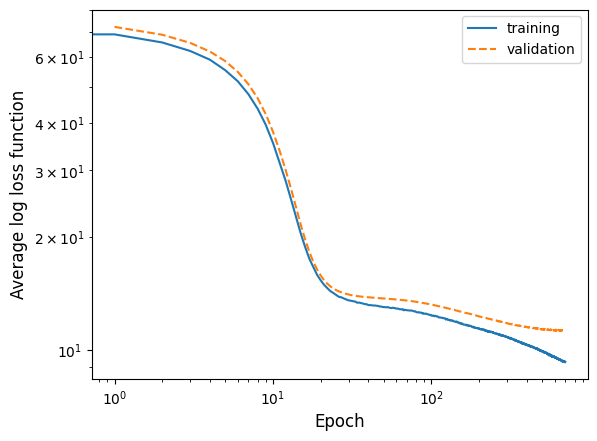

In [250]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='training') #train_value contains the values of the loss function for each epoch of the training set
plt.plot(epoche+1,valid_value,ls='--',label='validation') #valid_value contains the values of the loss function for each epoch of the validation set

plt.legend()
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average log loss function", fontsize=12)
plt.loglog()

In [251]:
# get the test data
test_loader = create_dataset('test', SFRD, parameters, batch_size, seed) #test data

# load the best-model and move it to the GPU because I want to use the best set of parameters found over training
model.load_state_dict(torch.load(f_model))
model.to(device=device)

#array where to store the true set of parameters and corresponding SFRD sims selected from the files for the test dataset
SFRD_T=np.zeros((int(SFRD.shape[0]*0.75),100), dtype=np.float32)
params_T = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)
#array where to store the network predictions for the parameters
params_N = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)
#array where to store the network predictions for the errors
sigma_N = np.zeros((int(SFRD.shape[0]*0.15),6), dtype=np.float32)

# loop over batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        # get the number of elements in the batch
        b_size = SFRD_test.shape[0]

        # move data to GPU
        SFRD_test   = SFRD_test.to(device)
        params_test = params_test.to(device)

        # compute the value predicted by the network by linear combination with the current set of parameters
        params_sigma_pred  = model(SFRD_test)

        params_pred = params_sigma_pred[:, :12 // 2]
        sigma_pred = params_sigma_pred[:, 12 // 2:]

        # compute loss
        loss = loss_func(params_pred, sigma_pred, params_test)

        SFRD_T[points:points+b_size, :] = SFRD_test.cpu().numpy()
        params_T[points:points+batch_size, :] = params_test.squeeze().cpu().numpy() #this array has the true values of the parameters used for the data in the test dataset
        params_N[points:points+batch_size, :] = params_pred.cpu().numpy() #this array has the values predicted by the net for the parameters used for the data in the test dataset
        sigma_N[points:points+batch_size, :] = sigma_pred.cpu().numpy() #this array has the errors predicted by the net for the parameters used for the data in the test dataset

        # compute cumulative loss and number of examples used
        test_loss += loss.item()*b_size
        points    += b_size

# get the average test loss
test_loss /= points

print('test loss = %.3e'%test_loss) #value of the loss function fot the test

#denormalize the parameters

min_params = np.min(parameters, axis=0) #min and max for each of the six params over the simulations
max_params = np.max(parameters, axis=0)

params_T = params_T*(max_params-min_params) + min_params
params_N = params_N*(max_params-min_params) + min_params
#devo riscalare anche la deviazione standard
sigma_N = sigma_N*(max_params-min_params)

test loss = 1.103e+01


<ipython-input-251-46a103c283f6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f_model))


###Plot dei risultati

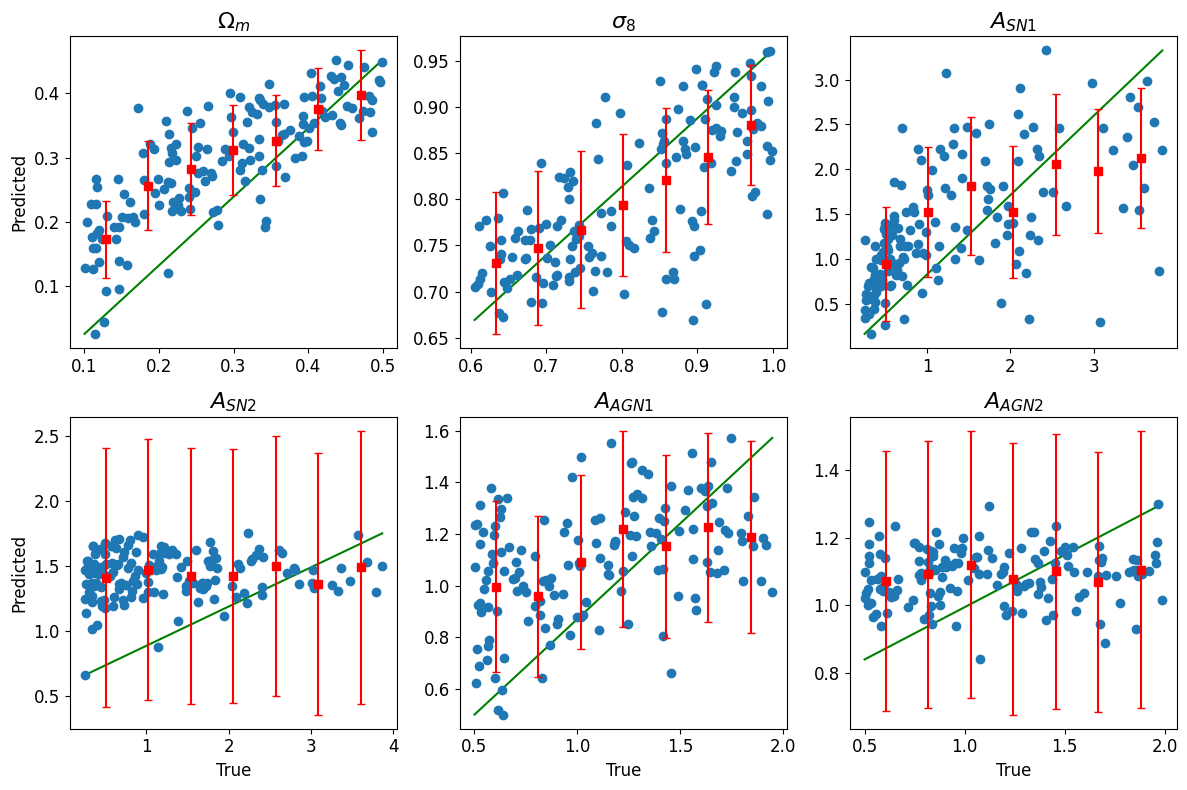

In [252]:
import scipy.stats as stats

bin_edges = []
min_T = np.zeros(6)
max_T = np.zeros(6)
min_N = np.zeros(6)
max_N = np.zeros(6)

var_N = sigma_N**2

for i in range(params_T.shape[1]):
  min_T[i] = np.min(params_T[:,i])
  max_T[i] = np.max(params_T[:,i])
  bin_edges.append(np.linspace(min_T[i], max_T[i], 8))

for i in range(params_N.shape[1]):
  min_N[i] = np.min(params_N[:,i])
  max_N[i] = np.max(params_N[:,i])

fig, axes = plt.subplots(2,3,figsize=(12,8))

title = ['$\Omega_m$', '$\sigma_8$', "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN1}$", "$A_{AGN2}$"]

for i, ax in enumerate(axes.flat):
  ax.scatter(params_T[:,i], params_N[:,i], zorder=1)

  ax.plot([min_T[i],max_T[i]],[min_N[i],max_N[i]], color = 'g', zorder=0)

  mean, bin_edges_x, binnumber = stats.binned_statistic(
      params_T[:,i], params_N[:,i], statistic=np.mean, bins=bin_edges[i])

  mean_var, _, _ = stats.binned_statistic(
      params_T[:,i], var_N[:,i], statistic=np.mean, bins=bin_edges[i])

  mean_sigma = np.sqrt(mean_var)

  ax.errorbar(bin_edges_x[:-1]+0.5*np.diff(bin_edges_x), mean, mean_sigma, fmt='s',color='r', capsize=3)

  ax.set_title(title[i], fontsize=16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

for i in range(3):
    axes[1, i].set_xlabel('True', fontsize=12)

for i in range(2):
    axes[i, 0].set_ylabel('Predicted', fontsize=12)

plt.tight_layout()

plt.show()

##Discussione dei risultati

Ad ogni simulazione la rete associa un set di parametri e relativo errore rispettivamente conenuti negli array *params_N* e *sigma_N*.
Per verificare che gli errori predetti dalla rete sulla sua stessa stima dei parametri siano plausibili, mi aspetto che per ciascuna simulazione la differenza tra valore vero e valore stimato dei parametri rientri in 1/2 deviazioni standard stimate dalla rete per ciascun parametro.

Per verificarlo graficamente, ai valori medi dei parametri predetti in ciascun bin sono state aggiunti i rispettivi errori calcolati a partire dalle deviazioni standard predette dalla rete.

$$(\sigma_k^{pred})^2 = \frac{1}{N_k}\sum_{i \in bin} (\sigma_i^{pred})^2$$

dove $\sigma_k^{pred}$ è la deviazione standard sulla media dei parametri nel k-esimo bin, $\sigma_i^{pred}$ sono gli errori predetti dalla rete contenuti in *sigma_N* e $N_k$ il numero di parametri predetti corrispondenti ai valori veri compresi nel k-esimo bin. Si suppone che le simulazioni siano tra loro indipendenti.

Siccome le barre di errore intersecano la bisettrice entro 1/2 deviazioni standard, la rete sembra predire correttamente gli errori che commette sulla stima dei parametri.

Si nota inoltre che gli errori predetti sui parametri $A_{SN2}$ e $A_{AGN2}$ sono eccessivi rispetto agli intervalli in cui variano le stime degli stessi, ciò è evidentemente dovuto alla pessima predizione che la rete fa di questi parametri.